# Use case 2: Clustering of Mall Customers with K-Means and AHC (Agglomerative/Ascending Hierarchical Clustering)

In this use case, we group drivers into several clusters based on their driving speed and distance, using K-Means and Hierarchical Clustering techniques.

**Clustering** is a technique where the goal is to group data points into clusters, or groups, based on their similarities. 
- The idea is that data points within the same cluster should be more similar to each other than to those in other clusters
- It’s commonly used in machine learning and statistics to explore patterns in data and is a type of unsupervised learning since it doesn’t require labeled data

  
**K-Means**

It is a clustering algorithm that groups data into  K  clusters by minimizing within-cluster variance (inertia)
- It assigns points to the nearest cluster centroid
- Recalculating centroids iteratively until stabilization
- It requires specifying  K  in advance, assumes spherical clusters
- It is sensitive to outliers and initial centroids


**Hierarchical Clustering**

It's a family of clustering algorithms that build nested clusters by successively:
- Merging them: **Agglomerative/Ascending Hierarchical Clustering**: each point being a cluster initially (bottom-up method)
- Or splitting them: **Divisive/Descending Hierarchical Clustering**: all point being a single cluster initially (top-down method)
- This hierarchy of clusters is represented as a tree (or **dendrogram**)


**Agglomerative/Ascending Hierarchical Clustering (AHC)**

It is a clustering technique where:
- Each data point being a cluster initially
- Clusters are successively merged together until reaching a single global cluster
- The **linkage criteria** determines the metric used for the merge strategy
- **Ascending** means that clusters are merged from the smallest to the largest 


**Linkage Criteria (Merging Rule)**

A rule must be defined to determine how to merge 2 elements:
- Single Linkage (nearest point): Distance between the closest points in the 2 groups
- Maximum/Complete Linkage (farthest point): Distance between the farthest points in the 2 groups
- Average Linkage: Average distance between all points in the 2 groups
- Ward’s Method: Minimizes the inertia within all clusters (similar to K-Means)


_____

**Students:**
- OUEDRAOGO Taoufiq
- TONDJI Andrea
- YATTASSAYE Ganda
- NANFAH Manoel
___


In [607]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sweetviz as sv
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, SparsePCA
import scipy.cluster.hierarchy as shc

In [1072]:
df = pd.read_csv('data/Mall_Customers.csv')
print(df.shape)
df.head()

(200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Exploratory Data Analysis

In [1056]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### Renaming Columns

In [1073]:
df.rename(columns={'Annual Income (k$)': 'Annual Income', 
    'Spending Score (1-100)': 'Spending Score'}, inplace=True)
df.head()

,CustomerID,Genre,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Removing column `CustomerID`

The `CustomerID` should be removed because:
- It’s just a unique identifier for each driver and doesn’t help in clustering based on driving patterns
- Including it adds noise to the model and distracts the algorithm from meaningful features like `Genre`, `Age`, `Annual Income` and `Spending Score`

- That could lead to irrelevant or overly detailed clusters, since each driver is treated as unique without any relation to driving behavior
- With 200 unique values (over 200 lines of data), it introduces unnecessary variance that doesn’t help the clustering process

Removing `CustomerID` ensures the clustering focuses on the relevant features

In [1074]:
# Drop the 'CustomerID' column from the DataFrame
df = df.drop(columns=['CustomerID'])
df.head()

,Genre,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Coefficient of Variation

- For `Age`: 35.96%, showing that age has relatively low variability compared to the mean
- For `Annual Income`: 43.37%, indicating higher variability in income relative to the mean
- For `Spending Score`: 51.44%, indicating that spending scores have the highest relative variability among the features

In [1082]:
num_df = df[['Age', 'Annual Income', 'Spending Score']]
stats = num_df.describe().T
stats['Coefficient of Variation'] = 100 * stats['std'] / stats['mean']
stats['Skewness'] = num_df.skew()
stats['Kurtosis'] = num_df.kurt()

stats

,count,mean,std,min,25%,50%,75%,max,Coefficient of Variation,Skewness,Kurtosis
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0,35.956261,0.485569,-0.671573
Annual Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0,43.369751,0.321843,-0.098487
Spending Score,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0,51.441278,-0.047220,-0.826629


In [1083]:
df['Genre'].value_counts(normalize=True)


Genre
Female    0.56
Male      0.44
Name: proportion, dtype: float64

                                             |      | [  0%]   00:00 -> (? left)


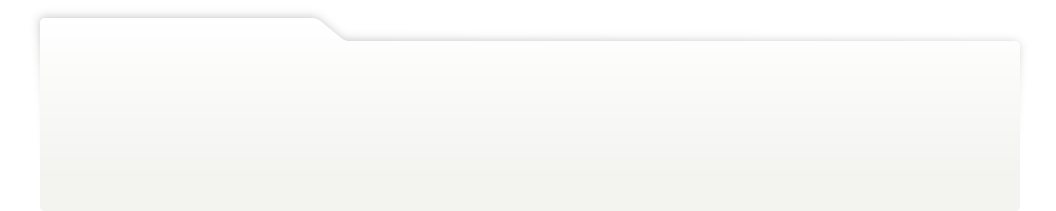
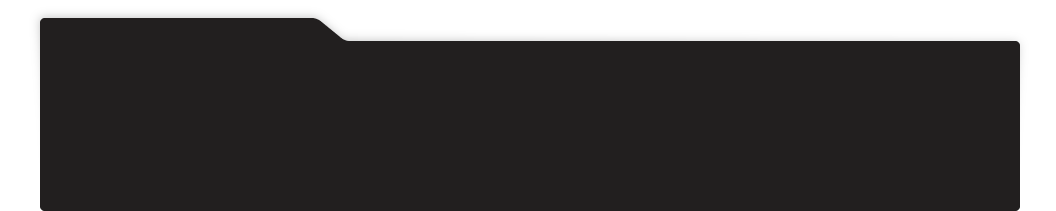
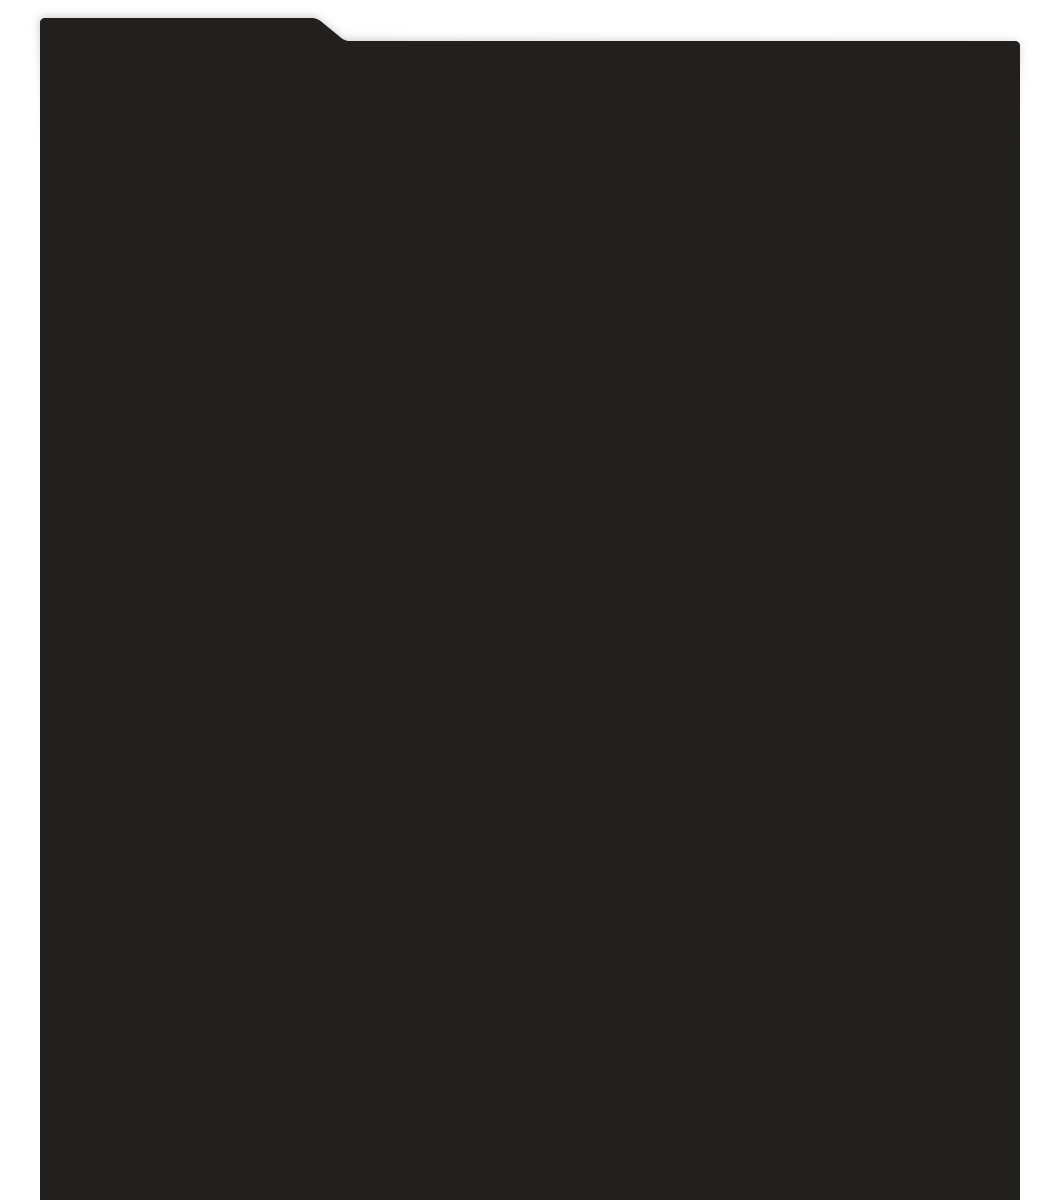
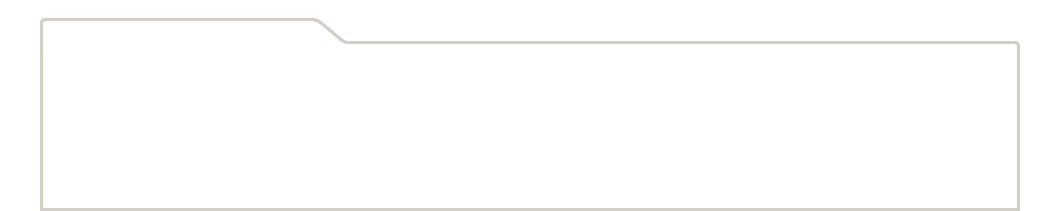
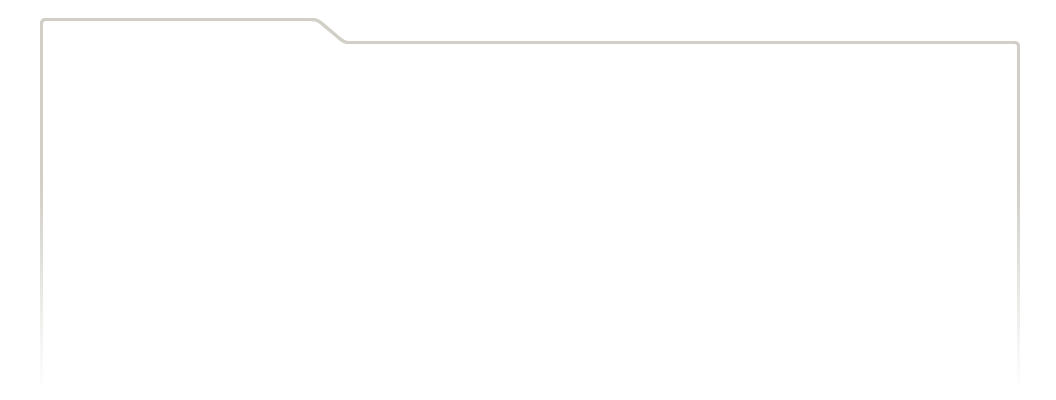
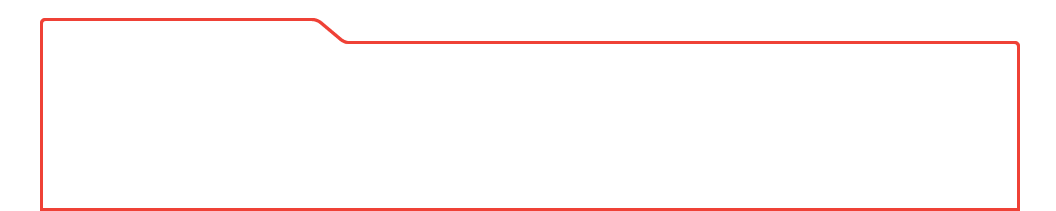
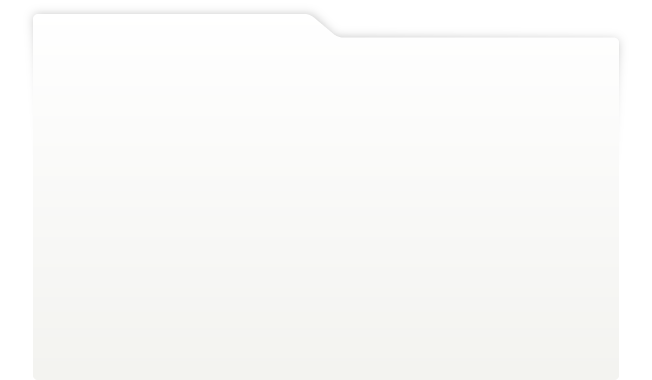
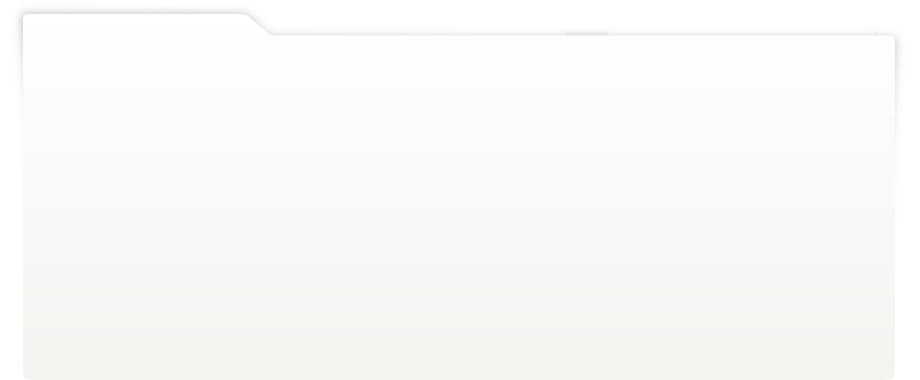
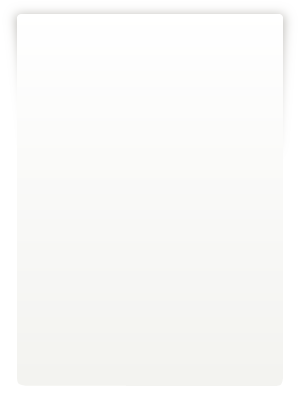
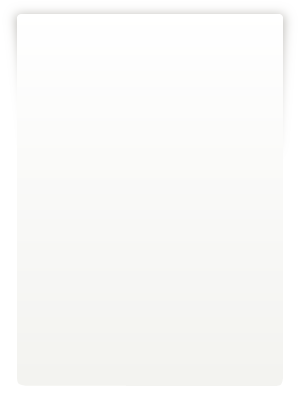
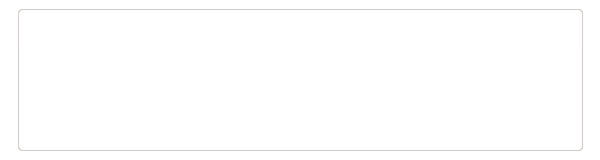
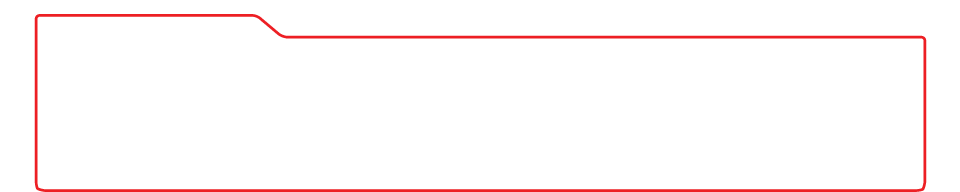
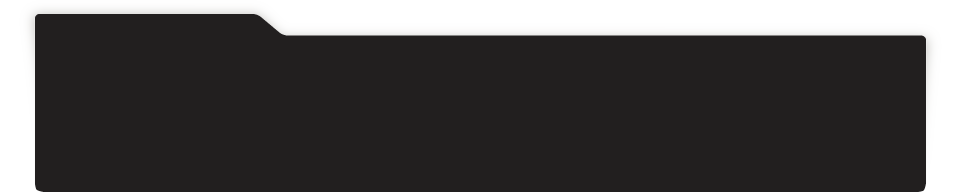
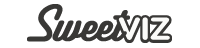
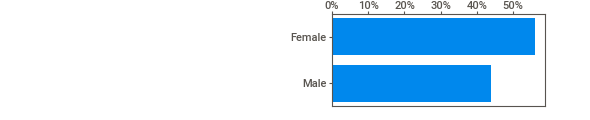
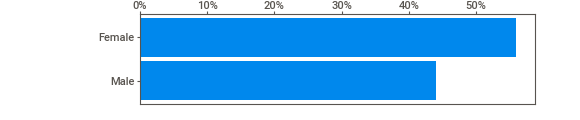
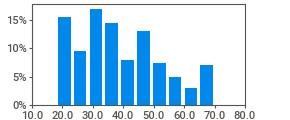
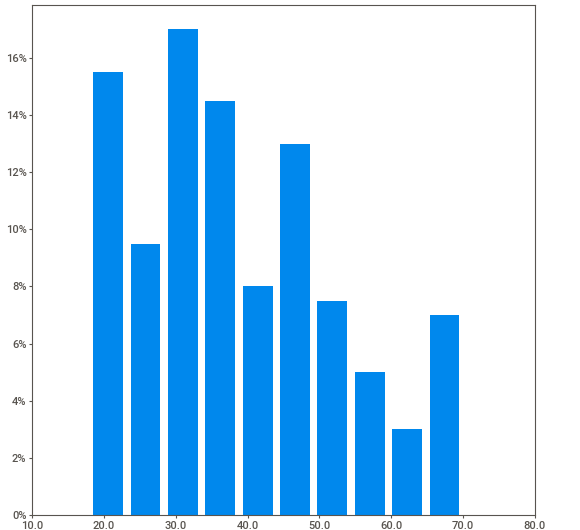
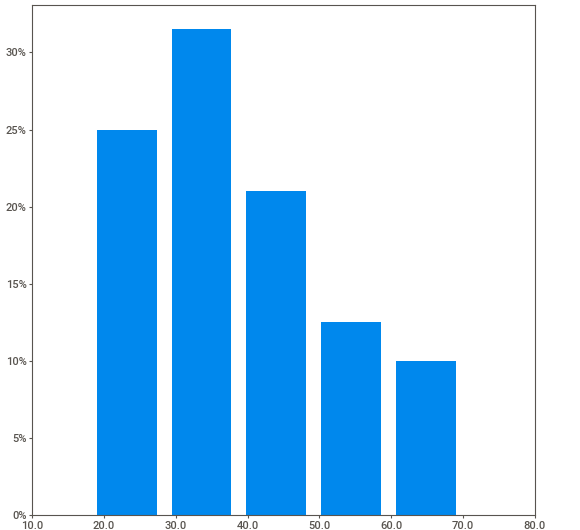
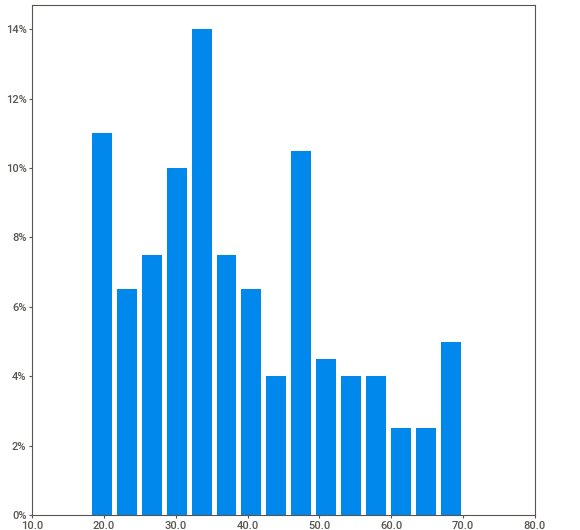
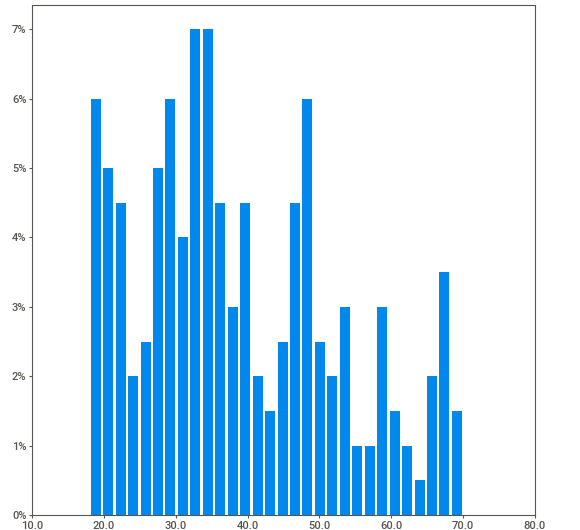
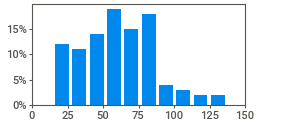
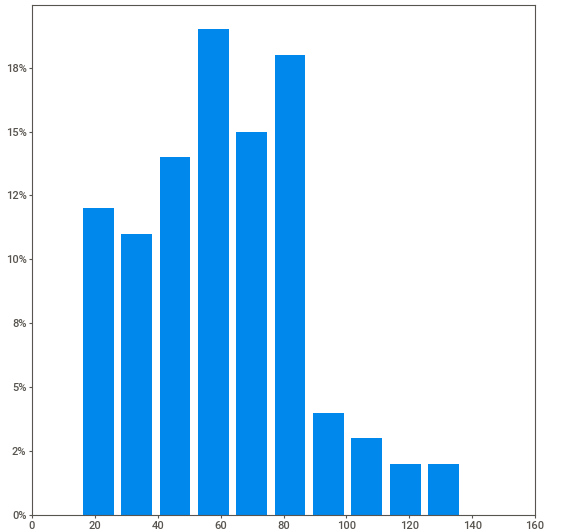
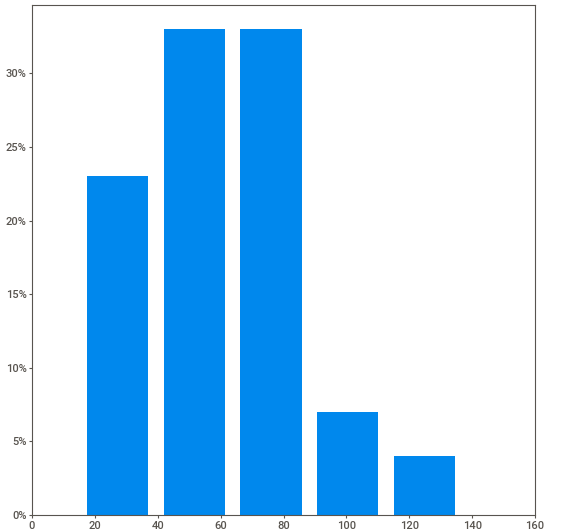
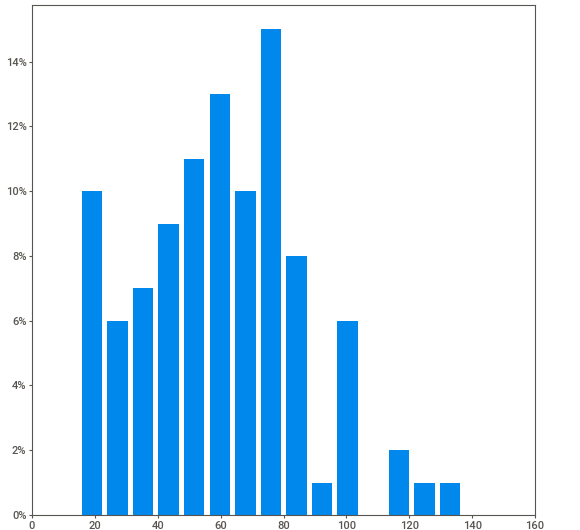
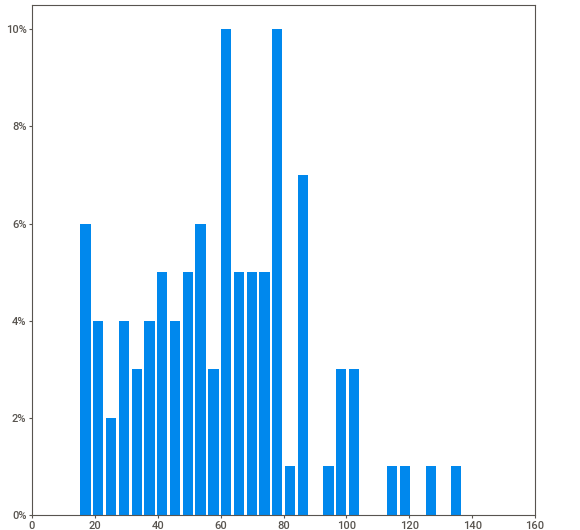
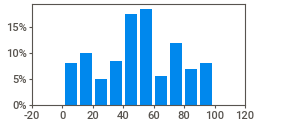
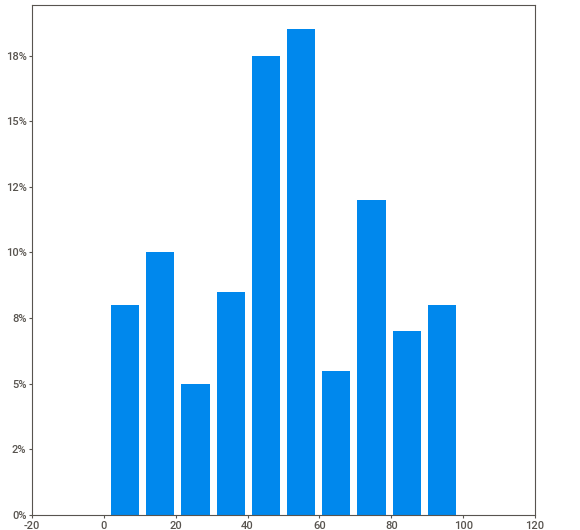
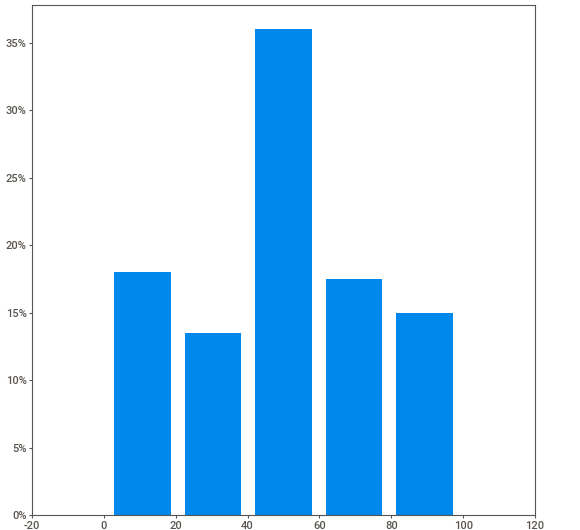
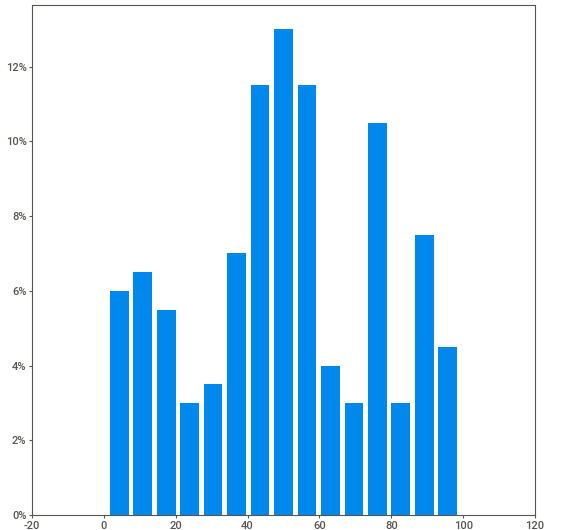
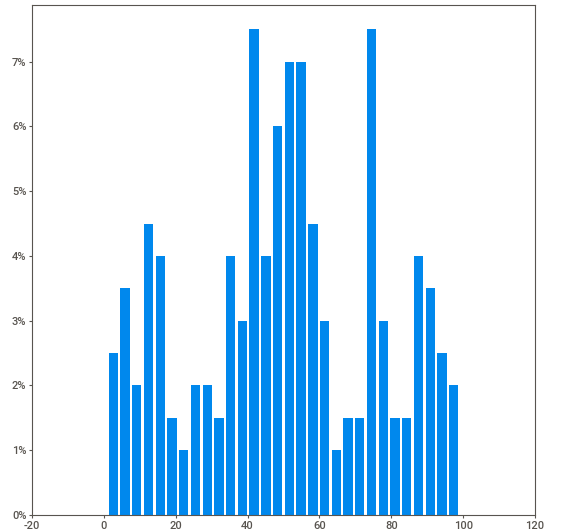
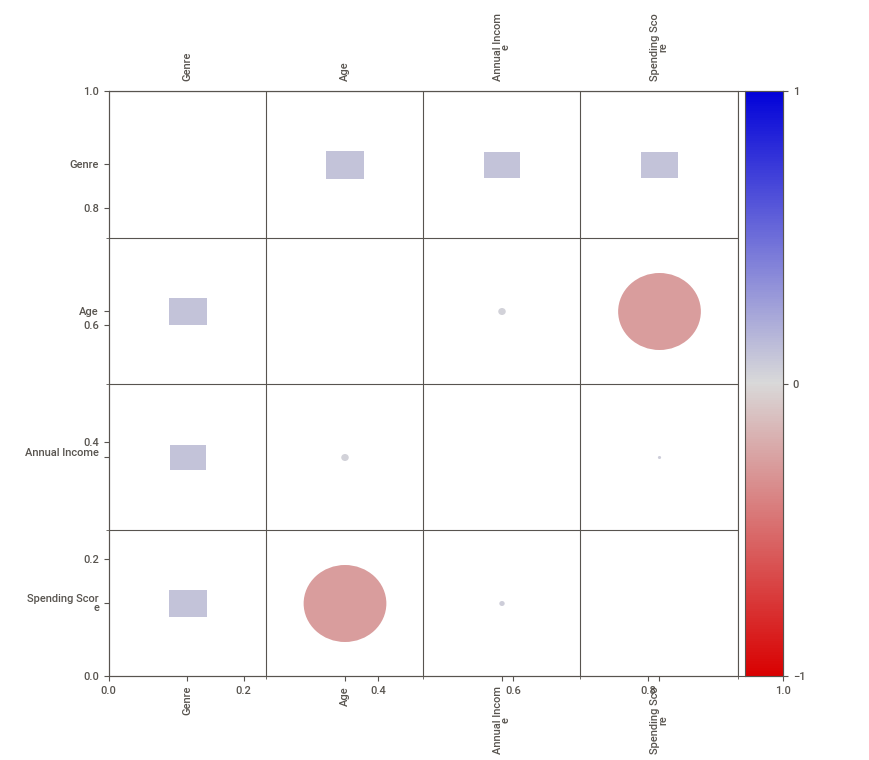
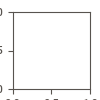

In [1062]:
# EDA: Sweetviz library to summarize main characteristics of the dataset
report = sv.analyze(df)
report.show_notebook(layout="vertical", w=880, h=500, scale=0.8)

### Plot between `Annual Income` and `Spending Score` reveals 5 apparent groups of customers

<Figure size 1000x300 with 0 Axes>

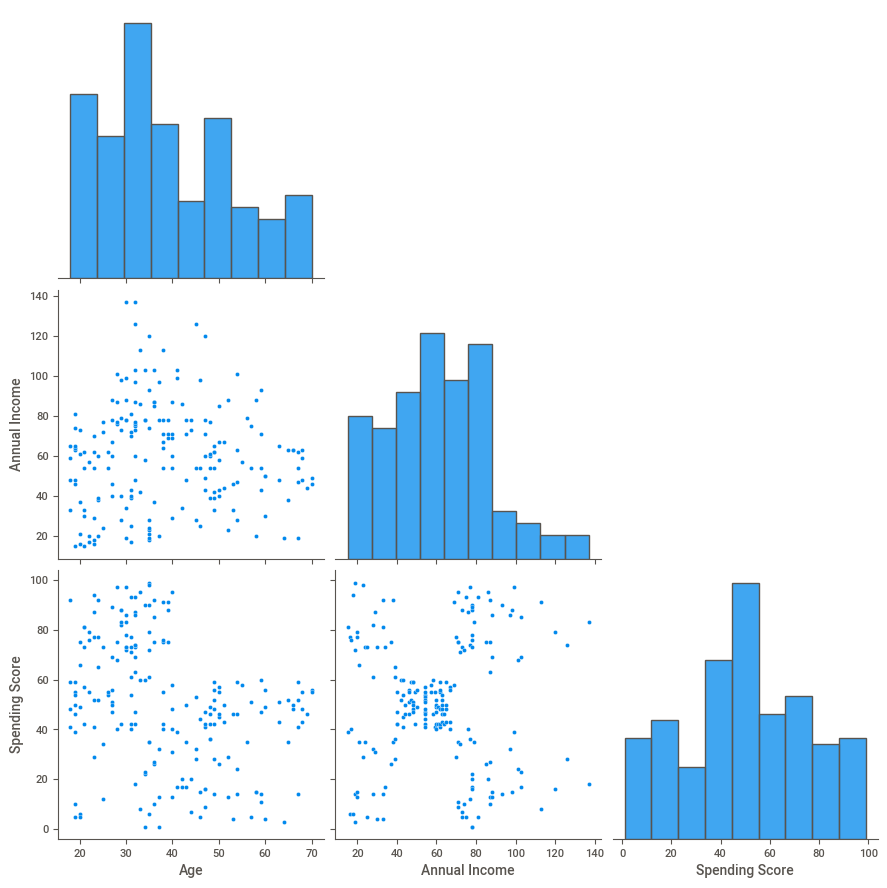

In [1086]:
plt.figure(figsize=(10, 3))
sns.pairplot(data=df, height=3, corner=True)
plt.show()

## Variables Distributions

- Spending Score has the most symmetric distribution with a skewness of -0.047
- Age and Annual Income are slightly positively skewed but close to symmetric

- Both Age and Spending Score have light tails, meaning fewer extreme values are present
- Annual Income is closest to a normal distribution, with kurtosis near zero

- Distributions with low skewness and light tails are less likely to introduce biases in models

> **These features may not need transformations for normality, as they are reasonably well-behaved in terms of symmetry and outliers**

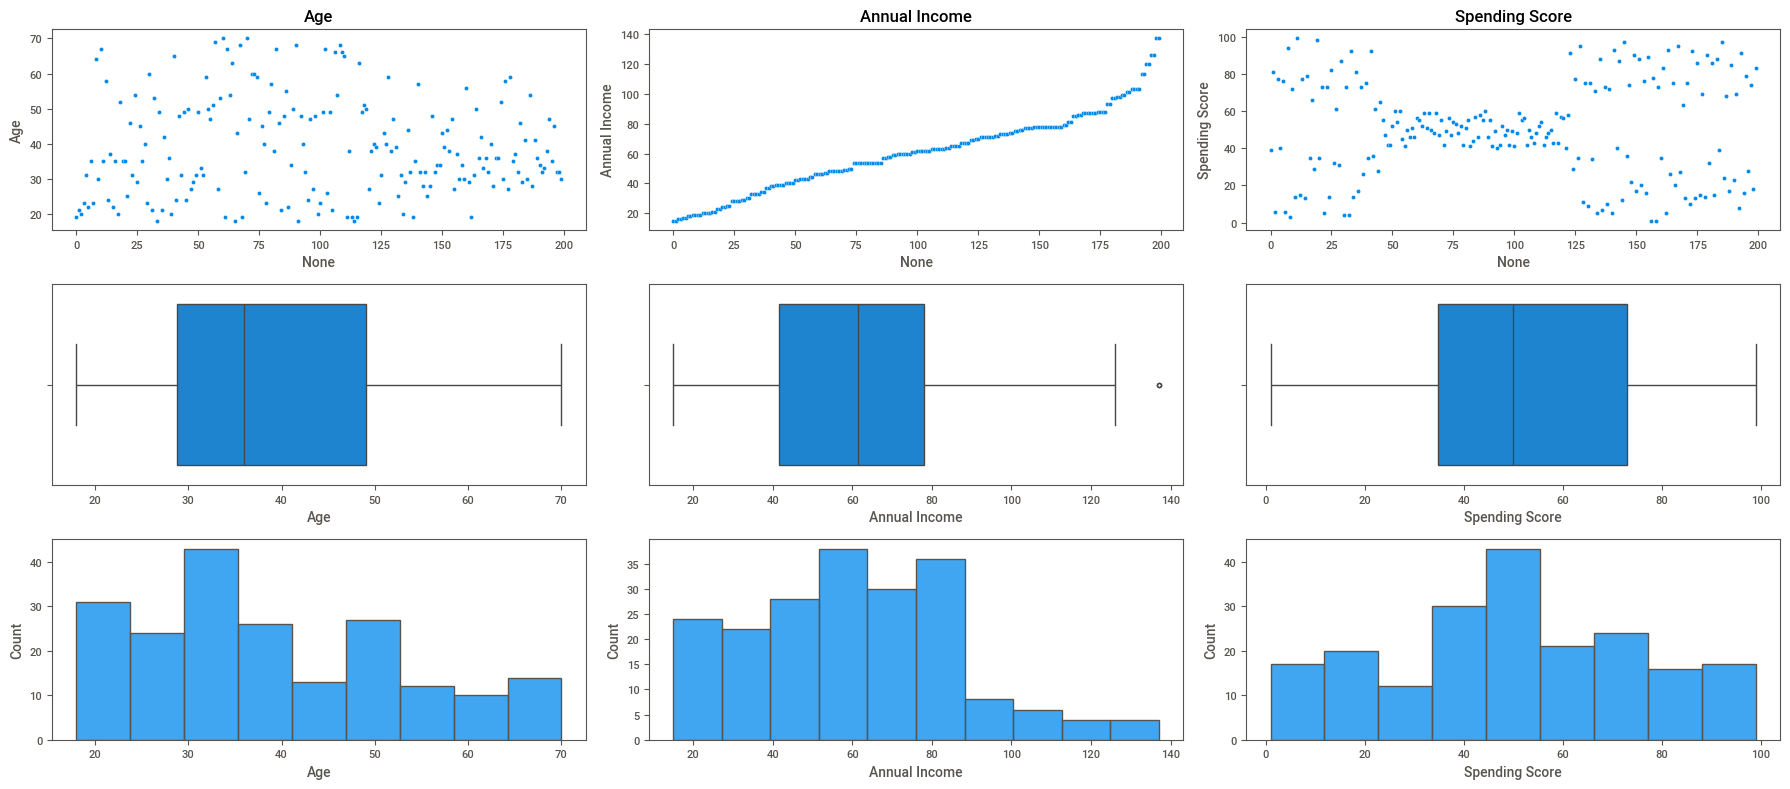

In [1084]:
fig, axes = plt.subplots(3, len(num_df.columns), figsize=(18, 8))

for i, c in enumerate(num_df.columns):
    sns.scatterplot(data=df, x=df.index, y=df[c], ax=axes[0, i])    
    sns.boxplot(data=df, x=df[c], ax=axes[1, i]) 
    sns.histplot(data=df, x=df[c], ax=axes[2, i]) 
    axes[0, i].set_title(f"{c}")
plt.tight_layout()
plt.show()

Proportion of Female/Male :
 Genre
Female    0.56
Male      0.44
Name: proportion, dtype: float64


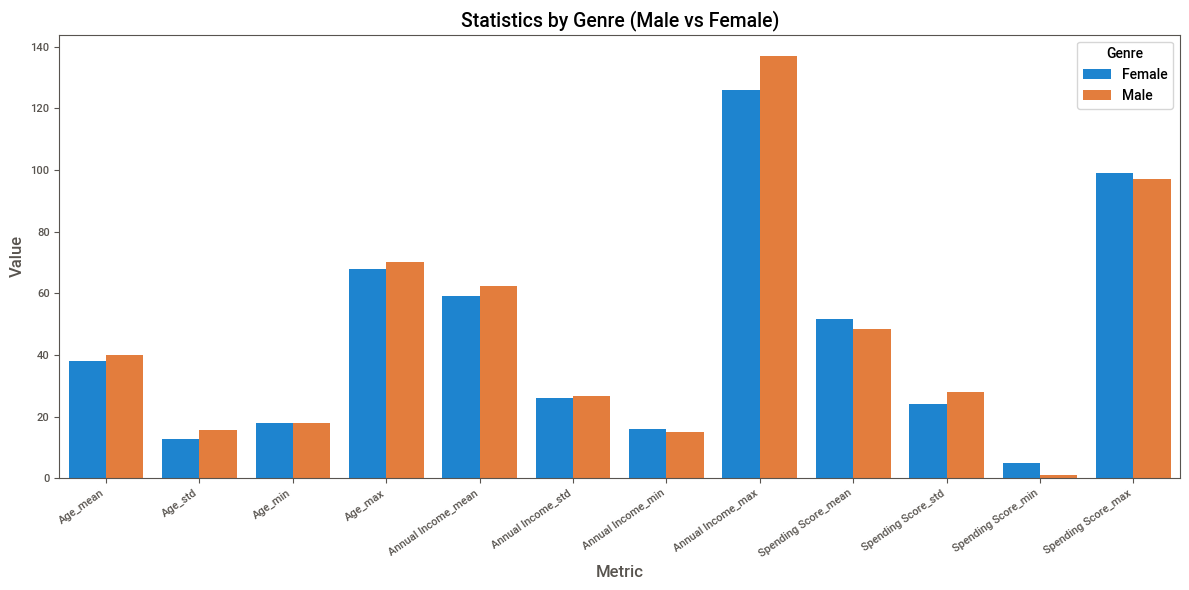

In [1085]:
# Proportion of Male and Female
print('Proportion of Female/Male :\n', df['Genre'].value_counts(normalize=True))

# Aggregate statistics by Genre
stats = df.groupby('Genre').agg({
    'Age': ['mean', 'std', 'min', 'max'],
    'Annual Income': ['mean', 'std', 'min', 'max'],
    'Spending Score': ['mean', 'std', 'min', 'max']
})

# Flatten multi-level columns and reset index for easier plotting
stats.columns = ['_'.join(col).strip() for col in agg_stats.columns.values]
stats.reset_index(inplace=True)

# Melt the DataFrame to make it long-form for easier plotting
stats_melted = stats.melt(id_vars=['Genre'], var_name='Metric', 
    value_name='Value', value_vars=[c for c in stats.columns if c != 'Genre'])

plt.figure(figsize=(12, 6))
sns.barplot(data=stats_melted, x='Metric', y='Value', hue='Genre')
plt.title('Statistics by Genre (Male vs Female)', fontsize=14)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

## Correlation

Correlation measures the strength of a relationship between 2 variables and the direction of that relationship
- Pearson Correlation: Measures the linear relationship between two variables
- Spearman Correlation: Measures the monotonic relationship between two variables
- Kendall Correlation: Measures the ordinal association between two variables

**Interpretation**

- The low value of Pearson Correlation indicates a weak positive linear relationship. As one feature increases, the other tends to increase slightly, since the relationship is not strong
- The Spearman Correlation indicates a weak positive monotonic relationship
- The Kendall Correlation shows a weak positive ordinal association between the two features
  
> **All 3 metrics indicate a weak positive relationship between `Distance_Feature` and `Speeding_Feature`**

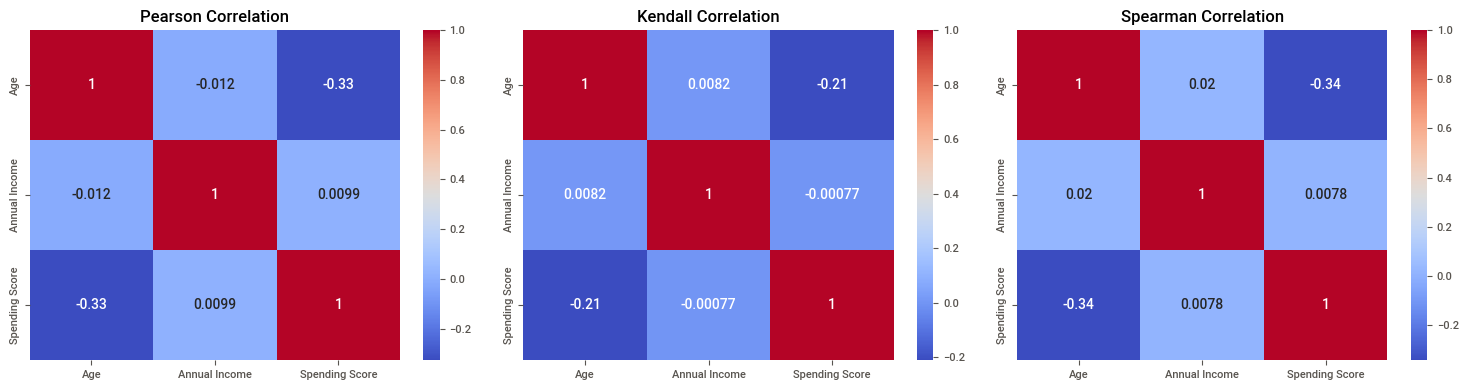

In [647]:
# Compute the correlation matrices with different methods
corr_pearson = df.corr(method='pearson', numeric_only=True)
corr_kendall = df.corr(method='kendall', numeric_only=True)
corr_spearman = df.corr(method='spearman', numeric_only=True)

# Pearson Correlation Heatmap
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax=axes[0], cbar=True)
axes[0].set_title('Pearson Correlation')

# Kendall Correlation Heatmap
sns.heatmap(corr_kendall, annot=True, cmap='coolwarm', ax=axes[1], cbar=True)
axes[1].set_title('Kendall Correlation')

# Spearman Correlation Heatmap
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=axes[2], cbar=True)
axes[2].set_title('Spearman Correlation')
plt.tight_layout()
plt.show()

In [1000]:
dfg = df.copy()
dfg['Genre'] = dfg['Genre'].map({'Male': 0, 'Female': 1})

df_ = df.drop(columns='Genre')

# Dimensionality Reduction with PCA, necessary?

Principal Component Analysis (PCA) creates **principal components**: new variables which are linear combination of original variables
- Statiscally, all components are uncorrelated/independent  
- Geometrically, all components are orthogonal/perpendicular to each other
- Each component preserves as much information as possible from the current dataset, capturing the maximum possible variation in the dataset


### Use Principal Components in a Model

It is hard to integrate components directly as a predicator into a model
- Since they don’t represent a single concept directly but are combinations of multiple variables
- For each PC, we can pick the original variable with the highest weight as a proxy 


In [1088]:
# Encoding the categorical variable
df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})

In [1090]:
n = len(df.columns)
pca = PCA(n_components=n, random_state = 444)
X_pca = pca.fit_transform(df) 

components = pd.DataFrame(X_pca, columns = [f'PC{i}' for i in range(1, n+1)])
ind = ["Proportion of variance", "Cumulative proportion of variance"]
cols = [f'PC{i}' for i in range(1, n+1)]  

l = range(1, n+1)
pr_var = pca.explained_variance_ratio_ * 100
cum_pr = np.cumsum(pr_var)

- PC1 explains 45% of the data variation
- PC2 explains 44% of the data variation
- PC3 explains 10% of the data variation

> **The first third combined components cover around 99.98% of the data variation, then we can apply a PCA with 3 components**


- For PC1, `Spending Score` has the highest absolute value of the coefficient, meaning it can be used as a proxy for PC1
- For PC2, `Annual Income` has the highest absolute value of the coefficient, meaning it can be used as a proxy for PC2
- For PC3, `Age` has the highest absolute value of the coefficient, meaning it can be used as a proxy for PC3

> **So, we can just choose `Spending Score`, `Annual Income` and `Age` for our model**


      Variance explained by PCA
|                                   |     PC1 |     PC2 |     PC3 |         PC4 |
|:----------------------------------|--------:|--------:|--------:|------------:|
| Proportion of variance            | 45.1181 | 44.0915 | 10.7746 |   0.0158175 |
| Cumulative proportion of variance | 45.1181 | 89.2096 | 99.9842 | 100         |


     Coefficients of Principal Components:

|                |          PC1 |         PC2 |         PC3 |          PC4 |
|:---------------|-------------:|------------:|------------:|-------------:|
| Genre          |  0.000332728 | -0.00157871 | -0.00146247 | -0.999998    |
| Age            | -0.188977    |  0.130961   |  0.973208   | -0.00169292  |
| Annual Income  |  0.588623    |  0.808388   |  0.00551457 | -0.00108843  |
| Spending Score |  0.786009    | -0.573895   |  0.229856   |  0.000831388 |



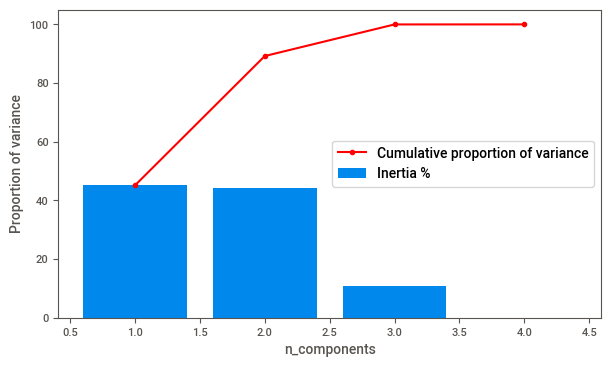

In [1101]:
# Variance explained by PCA
print('\n      Variance explained by PCA')
print(pd.DataFrame(np.vstack((pr_var, cum_pr)), index=ind, columns=cols).to_markdown(), end='\n\n')

# Coefficients of Principal Components
print('\n     Coefficients of Principal Components:\n')
print(pd.DataFrame(pca.components_.T, index=list(df.columns), columns=cols).to_markdown(), end='\n\n')

plt.figure(figsize=(7, 4))
plt.bar(l, pr_var, label='Inertia %') 
plt.plot(l, cum_pr, c="red", marker='o', label='Cumulative proportion of variance')  
plt.xlabel("n_components")
plt.ylabel("Proportion of variance")
plt.legend()
plt.show()  

Interestingly, compared to `Annual Income` and `Spending Score`:
- the same pattern appears when plotting `PC1` over `PC2`
- also, `Annual Income` and `Spending Score` could respectively be proxys for `PC1` over `PC2`
- confirming the presence of these 5 apparent clusters

**By focusing on just `Annual Income` and `Spending Score`, or on `PC1` and `PC2`**
- we can easily group customers. This analysis is meaningful because 
- it relies solely on these 2 variables
- making it easier to identify similarities among clients

**We can also add `Age` to further explore how it affects the clustering results**

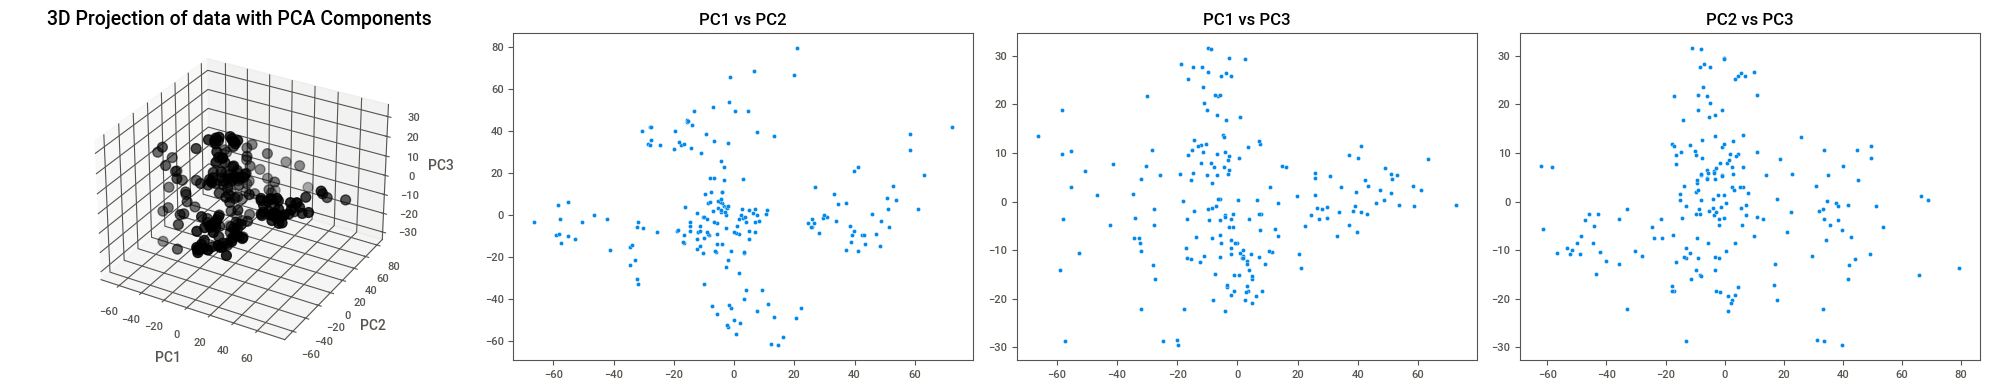

In [1114]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# 3D plot
ax_3d = fig.add_subplot(1, 4, 1, projection='3d')
scatter = ax_3d.scatter(components['PC1'], components['PC2'], components['PC3'], c='black', s=50)
ax_3d.set_title("3D Projection of data with PCA Components", fontsize=14)
ax_3d.set_xlabel("PC1")
ax_3d.set_ylabel("PC2")
ax_3d.set_zlabel("PC3")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].set(title=None, xlabel=None, ylabel=None, xticks=[], yticks=[])

# Scatterplots
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], ax=axes[1])
axes[1].set_title("PC1 vs PC2")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 2], ax=axes[2])
axes[2].set_title("PC1 vs PC3")

sns.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], ax=axes[3])
axes[3].set_title("PC2 vs PC3")
plt.tight_layout()
plt.show()

## Elbow Method (choose the best $k$) and Silhouette Score


**What is a good clustering?**
- **Minimize Intra-class Variance**: members of the same cluster are very close
- **Maximize Inter-class Variance**: separate clusters as much as possible, ensuring they are distinct from each other

**Inertia**
- Measure the spread/dispersion of data within a cluster (how compact the clusters are) 
- Lower inertia suggests better clustering


**Silhouette Score**
- Measures how well-separated and well-formed clusters are
- The higher, the better

$$  = 
\begin{cases}
    = 1 \text{ , means the point is perfectly match to its cluster}\\
    = 0 \text{ , means the point is on the border between clusters} \\
    < 0 \text{ , means the point might belong to another cluster}
\end{cases} 
$$

In [1122]:
def elbow_method(X):
    assert model_params.get('name') in ['kmean']
    # Start at 2 because silhouette score is undefined for k=1
    k_range = range(2, 20)  
    inertia = []
    silhouette_scores = []

    # Perform K-means clustering for each k and compute metrics
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42, init='k-means++')
        model.fit(X)
        inertia.append(model.inertia_)
        labels = model.labels_
        silhouette_scores.append(silhouette_score(X, labels))

    # Store the results in a DataFrame for easy plotting
    results_df = pd.DataFrame({'k': k_range, 'Inertia': inertia,
        'Silhouette': silhouette_scores})
    return results_df

### Extract the features for clustering 

The goal here is to experiment with different sets of features to understand how they impact clustering performance. By selecting varying combinations of variables, including:
- both the raw features (Annual Income, Spending Score, and Age)
- their transformed counterparts (PC1, PC2, PC3)
- we aim to explore how the inclusion of different components and scaling affects the clusters


By standardizing the features:
- we eliminate the potential bias from features with higher magnitudes, such as Annual Income
- we allow the clustering to treat all features equally
- The goal is to compare how using different feature sets affects the clustering results

In [1130]:
# Select PC1, PC2, PC3 from PCA (Spending Score, Annual Income, Age)
X_pca_3f = X_pca[:, :3]

# Select PC1, PC2 from PCA (Spending Score, Annual Income)
X_pca_2f = X_pca[:, :2]

# Select Spending Score, Annual Income, Age
X_3f = df[['Annual Income', 'Spending Score', 'Age']].values

# Select Spending Score, Annual Income
X_2f = df[['Annual Income', 'Spending Score']].values

# Standardized features
scaler = StandardScaler()

# Select Spending Score, Annual Income, Age and scaled
X_3f_scaled = scaler.fit_transform(X_3f)

# Select Spending Score, Annual Income and scaled
X_2f_scaled = scaler.fit_transform(X_2f)

Xs = {'X_pca_3f': X_pca_3f, 'X_pca_2f': X_pca_2f, 
'X_3f': X_3f, 'X_2f': X_2f,
'X_3f_scaled': X_3f_scaled, 'X_2f_scaled': X_2f_scaled,
}

In [1131]:
results_list = []
configs = []
for X_name, Xx in Xs.items():
    print(X_name)
    result = elbow_method(X=Xx)
    results_list.append(result)
    configs.append(X_name)

X_pca_3f
X_pca_2f
X_3f
X_2f
X_3f_scaled
X_2f_scaled


___

### Interpretation

Elbow method is often used to find the most appropriate value for k in clustering:
- by plotting inertia and silhouette score
- by visually identifying the “elbow” point, which suggests the ideal number of clusters


**Trade-off Between Complexity and Accuray**
- The elbow point represents the optimal trade-off
    > The point where adding more clusters stops providing significant improvement

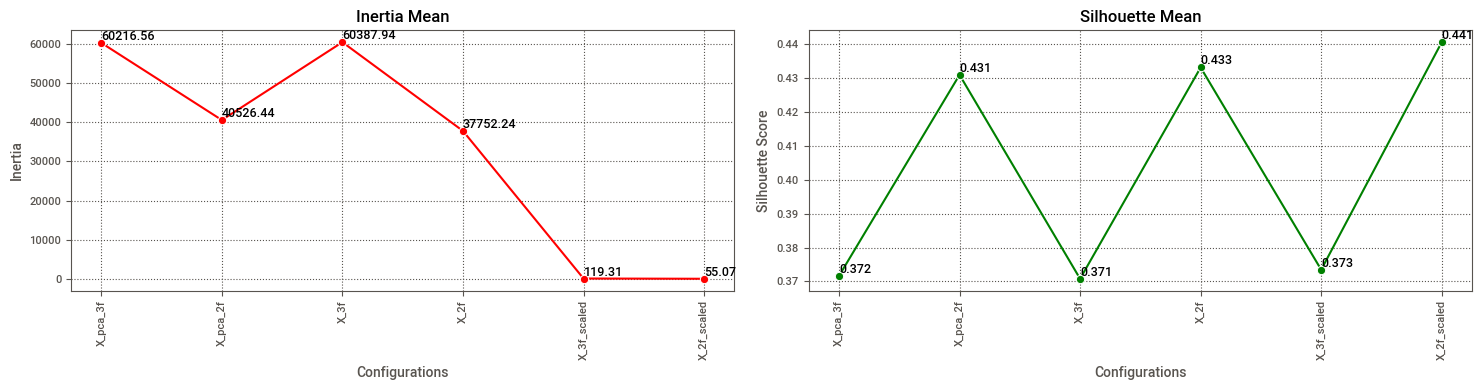

In [1141]:
inertia_mean = [r.mean()['Inertia'] for r in results_list]
Silhouette_mean = [r.mean()['Silhouette'] for r in results_list]
    
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
# Plot: Inertia
sns.lineplot(ax=axes[0], x=configs, y=inertia_mean, marker='o', c='r', markersize=6)
for x, y in zip(configs, inertia_mean):
    axes[0].text(x, y, f'{y:.2f}', fontsize=9, ha='left', va='bottom', color='black')
axes[0].set_title("Inertia Mean")
axes[0].set_ylabel("Inertia")
axes[0].grid(True, linestyle=':')
axes[0].tick_params(axis='x', rotation=40)

# Plot Silhouette
sns.lineplot(ax=axes[1], x=configs, y=Silhouette_mean, marker='o', c='g', markersize=6)
for x, y in zip(configs, Silhouette_mean):
    axes[1].text(x, y, f'{y:.3f}', fontsize=9, ha='left', va='bottom', color='black')
axes[1].set_title("Silhouette Mean")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(True, linestyle=':')
axes[1].tick_params(axis='x', rotation=40)
plt.tight_layout()
plt.show()

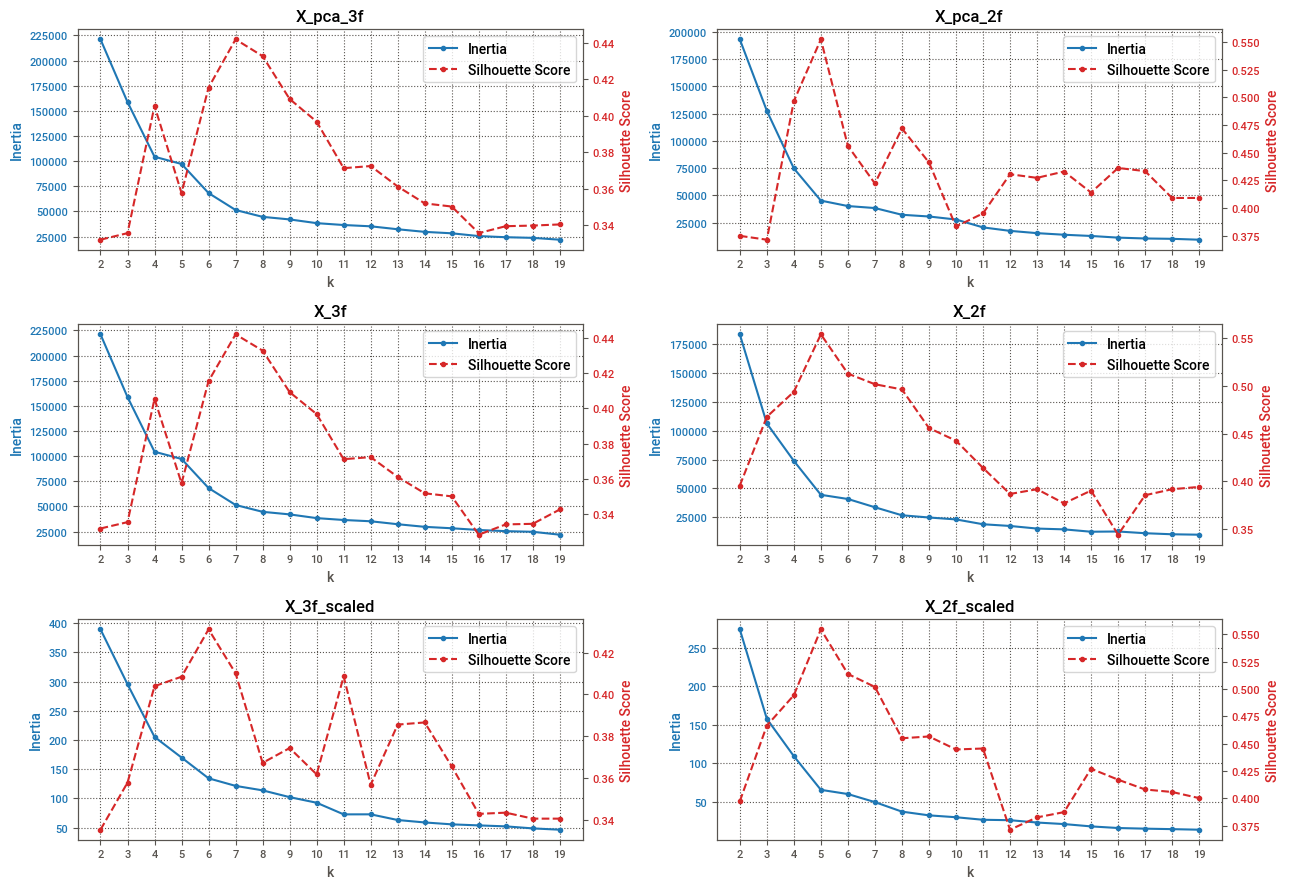

In [1138]:
n_dfs = len(results_list)
n_cols = 2
n_rows = int(np.ceil(n_dfs / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 3*n_rows))
axes = axes.flatten()  
for i, dfi in enumerate(results_list):
    ax1 = axes[i]
    
    # Plot Inertia on the primary y-axis
    color1 = 'tab:blue'
    ax1.plot(dfi['k'], dfi['Inertia'], marker='o', color=color1, label='Inertia')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xticks(dfi['k'])

    # Add secondary y-axis for Silhouette Score
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(dfi['k'], dfi['Silhouette'], marker='o', linestyle='--', color=color2, label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_xticks(dfi['k'])
    ax1.grid(True, linestyle=':') 
    ax1.set_title(f'{configs[i]}')

    # Combine legends for both y-axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

## Interpretation

X_2f_scaled (scaled Spending Score and Annual Income):
- produces the best clustering result in terms of inertia
- suggesting that scaling features helps to form more compact and well-separated clusters

However, the silhouette score being identical for all 3 feature sets (0.55):
- indicates that while scaling improves inertia, the overall quality of clustering (how well-separated the clusters are) doesn’t improve significantly



## Selection for KMEANS

From the graphs above, best featues are:
- X_pca_2f , k=5
- X_2f , k=5
- X_2f_scaled , k=5


The analysis indicates that clustering with k=5 using only `Annual Income` and `Spending Score` is the most effective approach
- The Elbow Method provides a solid basis for choosing k=5
- The clear visual separation of data points into 5 clusters further supports this choice.
- These findings suggest that these 2 features, when used alone, offer best results for segmenting customers


We could also test (X_3f_scaled , k=5) just to visualize its results.


In [1143]:
X_pca_2f.shape, X_2f.shape, X_2f_scaled.shape, X_3f_scaled.shape

((200, 2), (200, 2), (200, 2), (200, 3))

### Test Configuration: `X_3f_scaled` (`Spending Score`, `Annual Income`, `Age`) + Scaling, k=6

Inertia : 133.88887021131026
Silhouette Score : 0.4268547747113388 



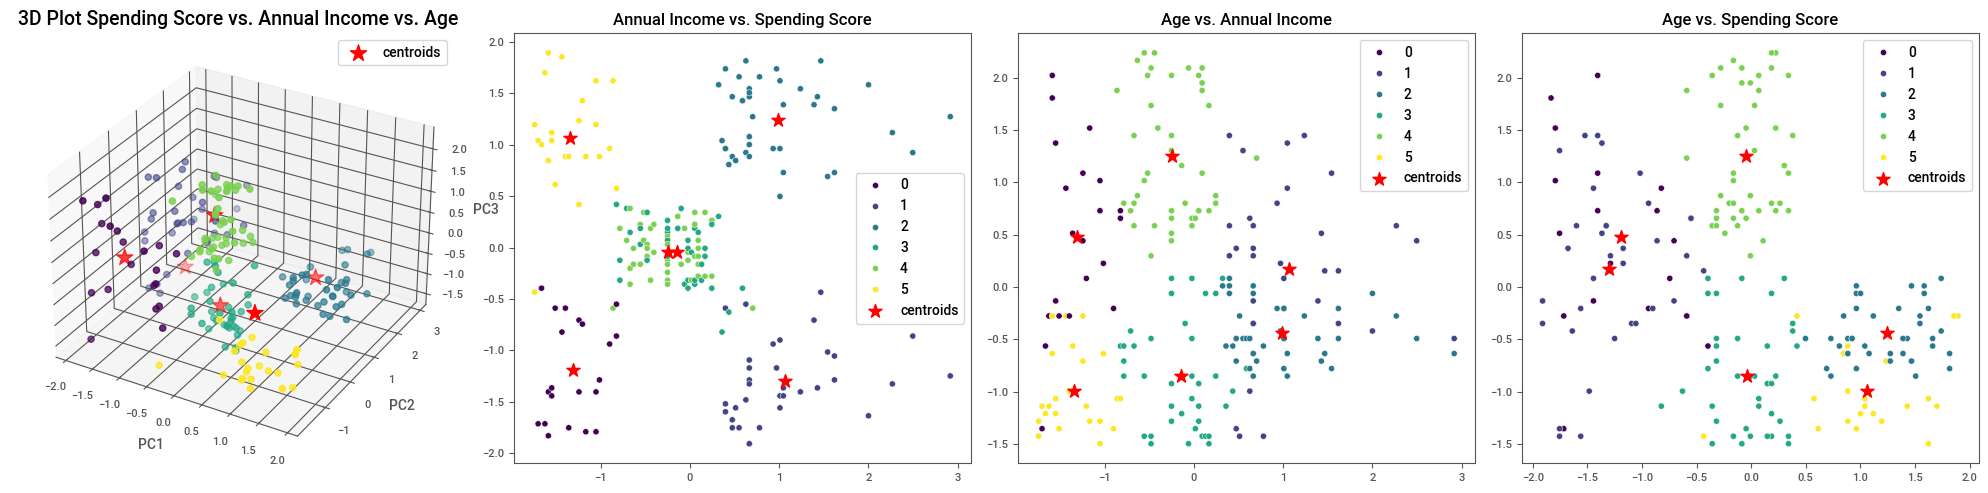

In [1159]:
kmean = KMeans(n_clusters=6, random_state=42, init='random')
kmean.fit(X_3f_scaled)

labels = kmean.labels_
print(f'Inertia : {kmean.inertia_}')
print(f'Silhouette Score : {silhouette_score(X_3f_scaled, labels)} \n')

df['Cluster'] = kmean.fit_predict(X_3f_scaled)
centroids = kmean.cluster_centers_

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# 3D plot
ax_3d = fig.add_subplot(1, 4, 1, projection='3d')
ax_3d.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], X_pca_scaled[:, 2], c=df['Cluster'], s=20)
ax_3d.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=150, c='r', marker='*', label='centroids')

ax_3d.set_title("3D Plot Spending Score vs. Annual Income vs. Age", fontsize=14)
ax_3d.set_xlabel("PC1")
ax_3d.set_ylabel("PC2")
ax_3d.set_zlabel("PC3")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
ax_3d.legend()
axes[0].set(title=None, xlabel=None, ylabel=None, xticks=[], yticks=[])

# Scatterplots
sns.scatterplot(x=X_3f_scaled[:, 0], y=X_3f_scaled[:, 1], ax=axes[1], data=df, hue='Cluster', palette='viridis', s=20)
axes[1].scatter(centroids[:, 0], centroids[:, 1], s=100, c='r', marker='*', label='centroids')
axes[1].set_title("Annual Income vs. Spending Score")
axes[1].legend()

sns.scatterplot(x=X_3f_scaled[:, 0], y=X_3f_scaled[:, 2], ax=axes[2], data=df, hue='Cluster', palette='viridis', s=20)
axes[2].scatter(centroids[:, 0], centroids[:, 2], s=100, c='r', marker='*', label='centroids')
axes[2].set_title("Age vs. Annual Income")
axes[2].legend()

sns.scatterplot(x=X_3f_scaled[:, 1], y=X_3f_scaled[:, 2], ax=axes[3], data=df, hue='Cluster', palette='viridis', s=20)
axes[3].scatter(centroids[:, 1], centroids[:, 2], s=100, c='r', marker='*', label='centroids')
axes[3].set_title("Age vs. Spending Score")
axes[3].legend()
plt.tight_layout()
plt.show()

### Configuration 1: `X_2f` (`Spending Score`, `Annual Income`), k=5

Inertia : 44448.45544793371
Silhouette Score : 0.553931997444648 



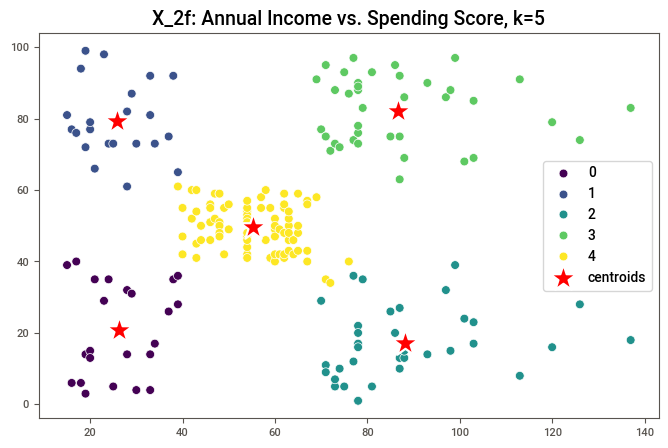

In [1174]:
kmean = KMeans(n_clusters=5, random_state=42, init='random')
kmean.fit(X_2f)

labels = kmean.labels_
print(f'Inertia : {kmean.inertia_}')
print(f'Silhouette Score : {silhouette_score(X_2f, labels)} \n')

df['Cluster'] = kmean.fit_predict(X_2f)
centroids = kmean.cluster_centers_

plt.figure(figsize=(8,5))
plt.title('X_2f: Annual Income vs. Spending Score, k=5', fontsize=14)
sns.scatterplot(data=df, x=X_2f[:, 0], y=X_2f[:, 1], hue='Cluster', palette="viridis", s=40)
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], s=400, c='r', marker='*', label='centroids')
plt.legend(loc='best')
plt.show()

### Configuration 2: `X_2f_scaled` (`Spending Score`, `Annual Income`) + Scaling, k=5

Inertia : 65.56840815571681
Silhouette Score : 0.5546571631111091 



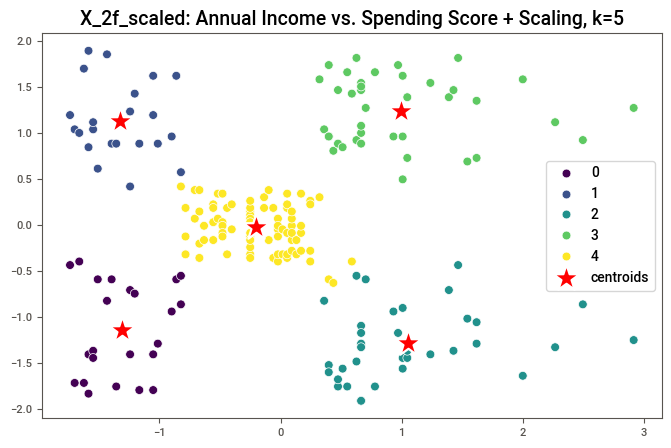

In [1177]:
kmean = KMeans(n_clusters=5, random_state=42, init='random')
kmean.fit(X_2f_scaled)

labels = kmean.labels_
print(f'Inertia : {kmean.inertia_}')
print(f'Silhouette Score : {silhouette_score(X_2f_scaled, labels)} \n')

df['Cluster'] = kmean.fit_predict(X_2f_scaled)
centroids = kmean.cluster_centers_

plt.figure(figsize=(8,5))
plt.title('X_2f_scaled: Annual Income vs. Spending Score + Scaling, k=5', fontsize=14)
sns.scatterplot(data=df, x=X_2f_scaled[:, 0], y=X_2f_scaled[:, 1], hue='Cluster', palette="viridis", s=40)
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], s=400, c='r', marker='*', label='centroids')
plt.legend(loc='best')
plt.show()

### Configuration 3: `X_pca_2f` (`PC1`, `PC2` from PCA, approximated by `Spending Score`, `Annual Income`), k=5

Inertia : 45092.05171373356
Silhouette Score : 0.5526264331833406 



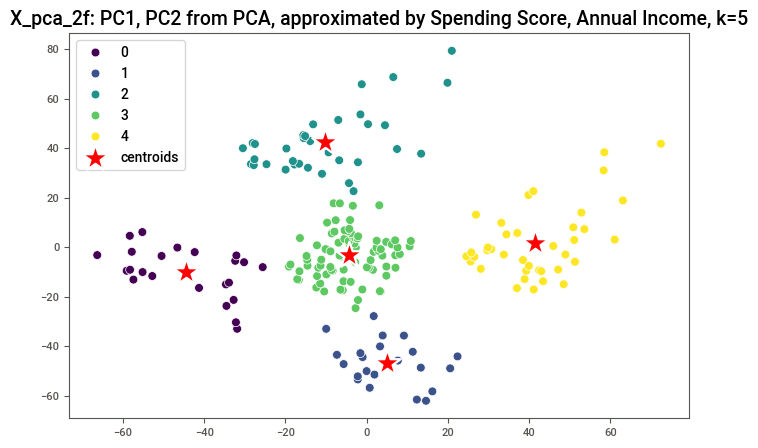

In [1176]:
kmean = KMeans(n_clusters=5, random_state=42, init='random')
kmean.fit(X_pca_2f)

labels = kmean.labels_
print(f'Inertia : {kmean.inertia_}')
print(f'Silhouette Score : {silhouette_score(X_pca_2f, labels)} \n')

df['Cluster'] = kmean.fit_predict(X_pca_2f)
centroids = kmean.cluster_centers_

plt.figure(figsize=(8,5))
plt.title('X_pca_2f: PC1, PC2 from PCA, approximated by Spending Score, Annual Income, k=5', fontsize=14)
sns.scatterplot(data=df, x=X_pca_2f[:, 0], y=X_pca_2f[:, 1], hue='Cluster', palette="viridis", s=40)
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], s=400, c='r', marker='*', label='centroids')
plt.legend(loc='best')
plt.show()

# Agglomerative/Ascending Hierarchical Clustering (AHC)


### Dendrogram
It is the tree we construct during Hierarchical Classification steps, it's:
- A visual representation of the hierarchical clustering process
- Displays the value of the criterion used

- Each level of the tree represents a fusion of 2 clusters
- The height of the branches represents distance between clusters being merged (valye on y-axis)


### Linkage Methods

Defines how the distance between 2 clusters is calculated when combining them

- Single Linkage (Nearest Neighbors): the shortest distance between any 2 points in the 2 clusters
- Maximum/Complete Linkage (Furthest point): the longest distance between any 2 points in the 2 clusters
- Average Linkage: the average distance between all pairs of points in the 2 clusters
- Weighted Linkage: the weighted average of distances between their individual points
- Centroid Linkage: the distance between centroids in the 2 clusters
- Ward’s Method: the inertia within all clusters (similar to K-Means)



### Distance Metrics

Measures the distance between clusters, following the Linkage method:

- Euclidean
- Manhattan
- Minkowski
- Cosine
- Jaccard

  

## Identify the Optimal Number of Clusters with Dendrogram
- Identify the longest vertical line that does not intersect with any horizontal lines (level)
- Draw a horizontal line through it, that line represents the threshold
- Number of clusters = number of vertical lines intersected by the horizontal threshold line


  
The threshold line intersects 5 vertical lines:
- hence we can conclude that the number of clusters we can have as 5

In [ ]:
X_pca_2f.shape, X_2f.shape, X_2f_scaled.shape, X_3f_scaled.shape

### Configuration 1: `X_2f` (`Spending Score`, `Annual Income`), k=5

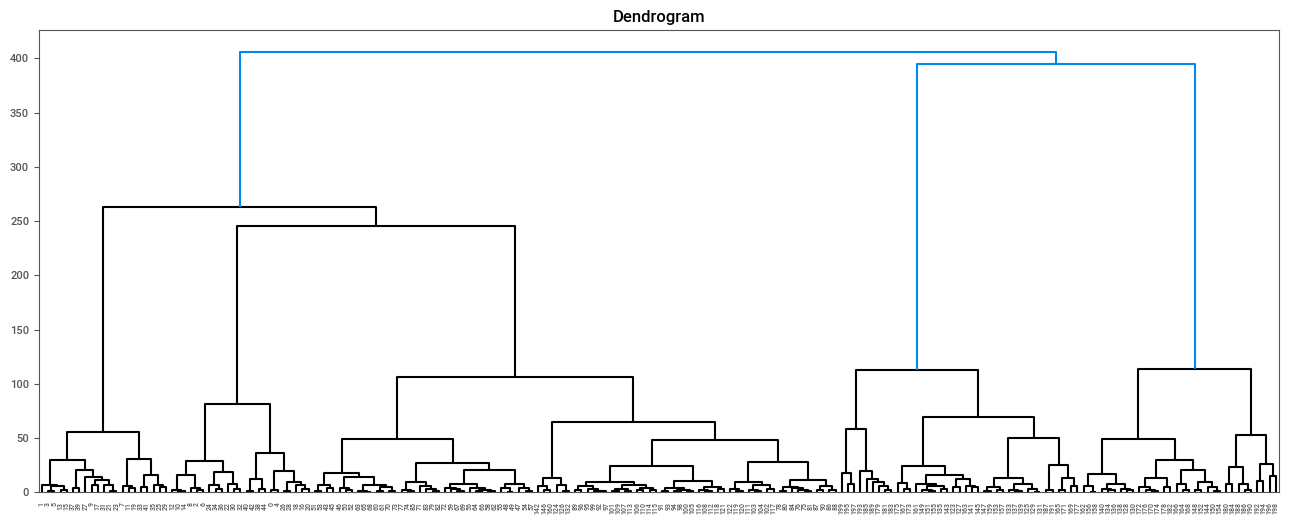

In [1211]:
## Build dendrogram to find out the optimal number of clusters
plt.figure(figsize=(16, 6))
clusters = shc.linkage(X_2f, method='ward', metric="euclidean")
dendrogram = shc.dendrogram(Z=clusters)
plt.title("Dendrogram")
plt.show()

**Step1: plot all the horizontal lines (representing merges)**

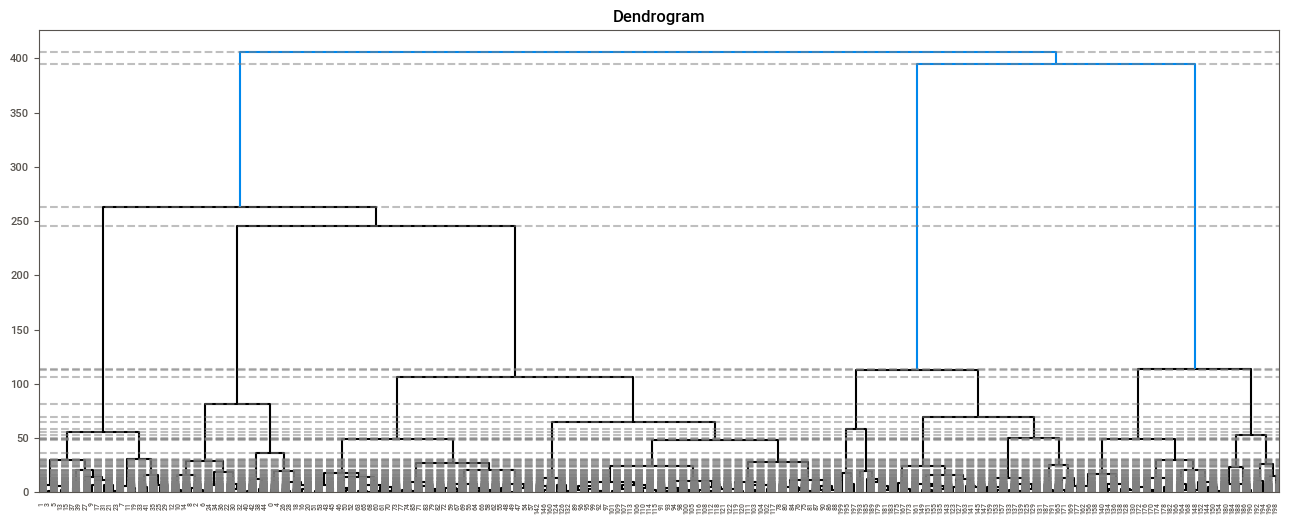

In [1240]:
plt.figure(figsize=(16, 6))
clusters = shc.linkage(X_2f, method='ward', metric="euclidean")
dendrogram = shc.dendrogram(Z=clusters)

# Draw horizontal lines for each merge level
# Heights of merges (3rd column of linkage matrix)
merge_heights = clusters[:, 2]  
for height in merge_heights:
    plt.axhline(y=height, color='gray', linestyle='--', alpha=0.5)

plt.title("Dendrogram")
plt.show()

**Step2: Identify the longest vertical line that does not intersect with any horizontal lines**

In [1235]:
# Calculate differences between i and i+1
# periods=1 calculates i - (i-1)
diff_heights = pd.Series(merge_heights).diff(periods=1)
idxmax = diff_heights.idxmax()

upper_bound = merge_heights[idxmax]
lower_bound = merge_heights[idxmax - 1]

(199,)


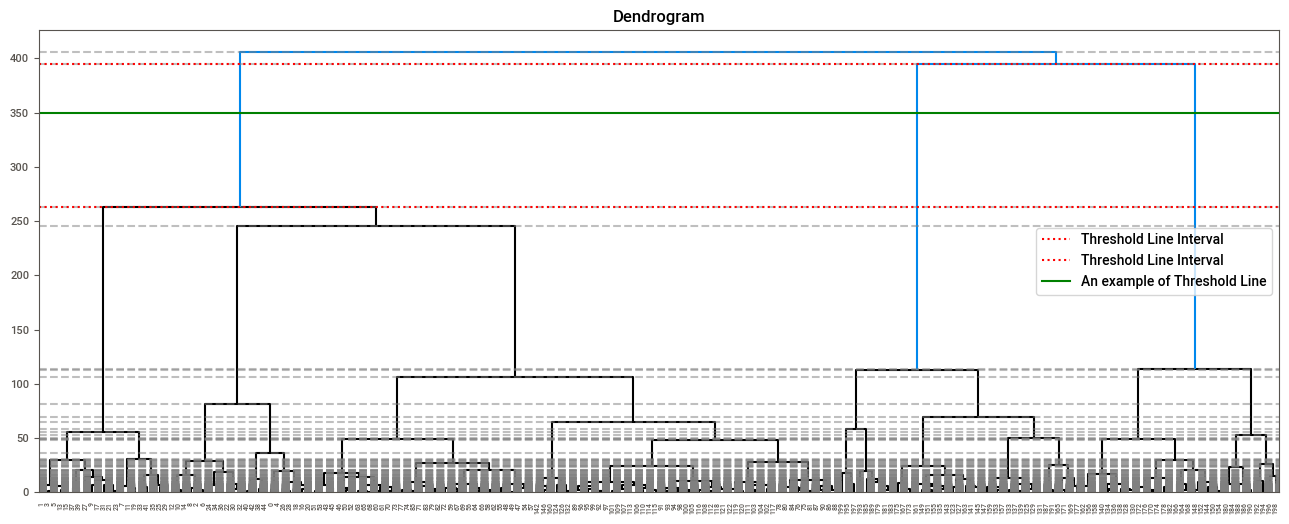

In [1243]:
plt.figure(figsize=(16, 6))
clusters = shc.linkage(X_2f, method='ward', metric="euclidean")
dendrogram = shc.dendrogram(Z=clusters)

# Draw horizontal lines for each merge level
# Heights of merges (3rd column of linkage matrix)
merge_heights = clusters[:, 2]  
for height in merge_heights:
    plt.axhline(y=height, color='gray', linestyle='--', alpha=0.5)
    
plt.axhline(y=upper_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=lower_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=350, color='green', label='An example of Threshold Line')
plt.title("Dendrogram")
plt.legend()
plt.show()

Silhouette Score : 0.4618340266628975


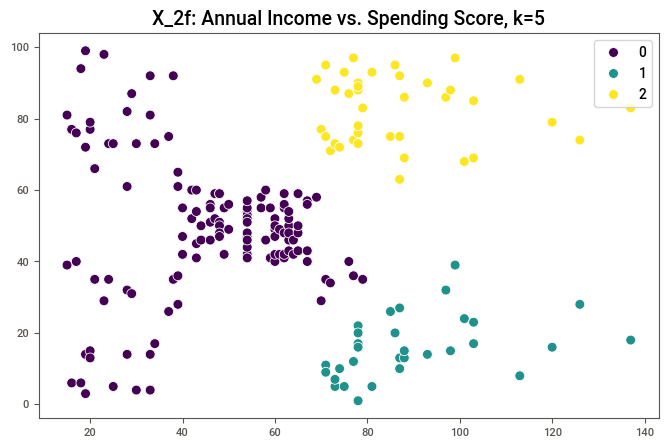

In [1244]:
ach = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df['Cluster'] = ach.fit_predict(X_2f)
labels = ach.labels_

print(f'Silhouette Score : {silhouette_score(X_2f, labels)}')

df['Cluster'] = ach.fit_predict(X_2f)

plt.figure(figsize=(8,5))
plt.title('X_2f: Annual Income vs. Spending Score, k=5', fontsize=14)
sns.scatterplot(data=df, x=X_2f[:, 0], y=X_2f[:, 1], hue='Cluster', palette="viridis", s=50)
plt.legend(loc='best')
plt.show()

### Configuration 2: `X_pca_2f` (`PC1`, `PC2` from PCA, approximated by `Spending Score`, `Annual Income`), k=5

(199,)


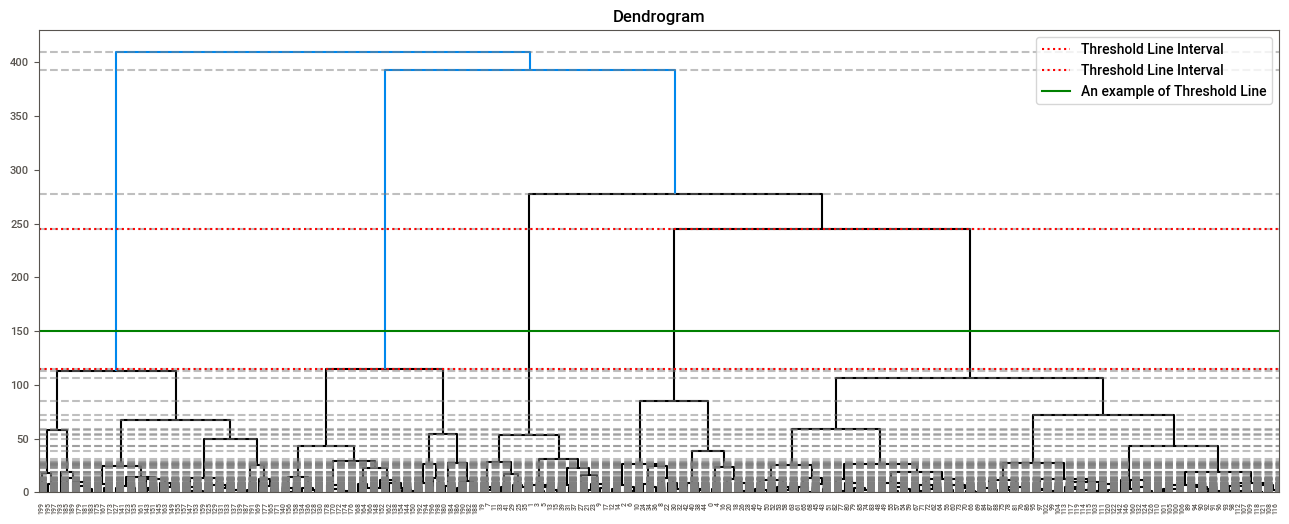

In [1249]:
plt.figure(figsize=(16, 6))
clusters = shc.linkage(X_pca_2f, method='ward', metric="euclidean")
dendrogram = shc.dendrogram(Z=clusters)

# Draw horizontal lines for each merge level
# Heights of merges (3rd column of linkage matrix)
merge_heights = clusters[:, 2]  
for height in merge_heights:
    plt.axhline(y=height, color='gray', linestyle='--', alpha=0.5)

# Calculate differences between i and i+1
# periods=1 calculates i - (i-1)
diff_heights = pd.Series(merge_heights).diff(periods=1)
idxmax = diff_heights.idxmax()
upper_bound = merge_heights[idxmax]
lower_bound = merge_heights[idxmax - 1]

plt.axhline(y=upper_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=lower_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=150, color='green', label='An example of Threshold Line')
plt.title("Dendrogram")
plt.legend()
plt.show()

Silhouette Score : 0.547778563852905


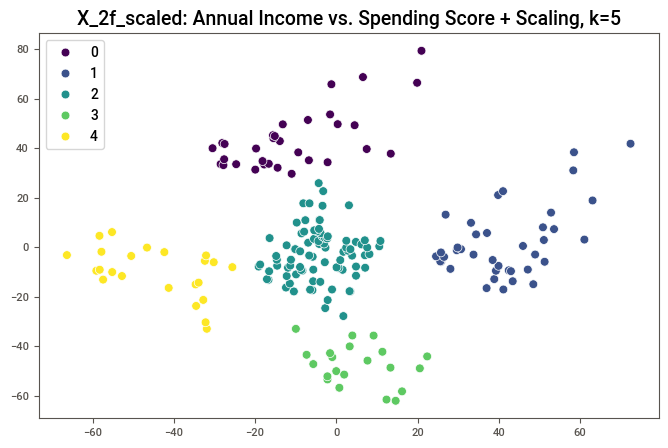

In [1250]:
ach = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
df['Cluster'] = ach.fit_predict(X_pca_2f)
labels = ach.labels_

print(f'Silhouette Score : {silhouette_score(X_pca_2f, labels)}')

df['Cluster'] = ach.fit_predict(X_pca_2f)

plt.figure(figsize=(8,5))
plt.title('X_2f_scaled: Annual Income vs. Spending Score + Scaling, k=5', fontsize=14)
sns.scatterplot(data=df, x=X_pca_2f[:, 0], y=X_pca_2f[:, 1], hue='Cluster', palette="viridis", s=40)
plt.legend(loc='best')
plt.show()

### Configuration 2: `X_2f_scaled` (`Spending Score`, `Annual Income`) + Scaling, k=5

(199,)


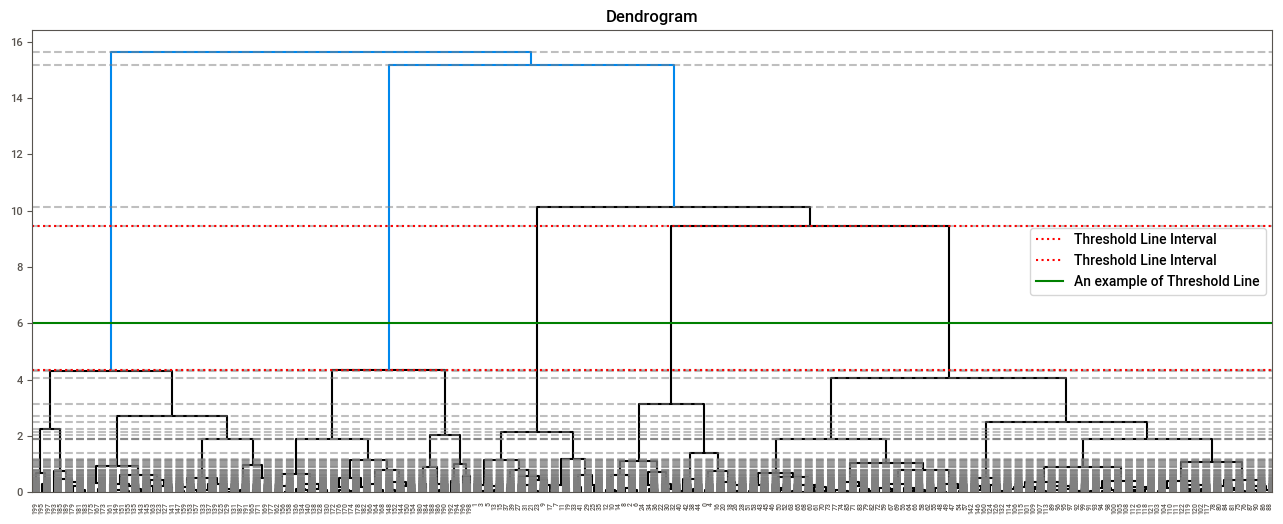

In [1246]:
plt.figure(figsize=(16, 6))
clusters = shc.linkage(X_2f_scaled, method='ward', metric="euclidean")
dendrogram = shc.dendrogram(Z=clusters)

# Draw horizontal lines for each merge level
# Heights of merges (3rd column of linkage matrix)
merge_heights = clusters[:, 2]  
for height in merge_heights:
    plt.axhline(y=height, color='gray', linestyle='--', alpha=0.5)

# Calculate differences between i and i+1
# periods=1 calculates i - (i-1)
diff_heights = pd.Series(merge_heights).diff(periods=1)
idxmax = diff_heights.idxmax()
upper_bound = merge_heights[idxmax]
lower_bound = merge_heights[idxmax - 1]

plt.axhline(y=upper_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=lower_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=6, color='green', label='An example of Threshold Line')
plt.title("Dendrogram")
plt.legend()
plt.show()

Silhouette Score : 0.5538089226688662


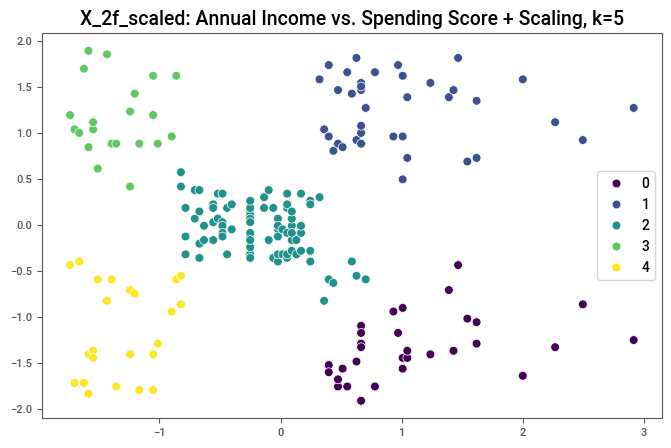

In [1247]:
ach = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
df['Cluster'] = ach.fit_predict(X_2f_scaled)
labels = ach.labels_

print(f'Silhouette Score : {silhouette_score(X_2f_scaled, labels)}')

df['Cluster'] = ach.fit_predict(X_2f_scaled)

plt.figure(figsize=(8,5))
plt.title('X_2f_scaled: Annual Income vs. Spending Score + Scaling, k=5', fontsize=14)
sns.scatterplot(data=df, x=X_2f_scaled[:, 0], y=X_2f_scaled[:, 1], hue='Cluster', palette="viridis", s=40)
plt.legend(loc='best')
plt.show()

___

## Interpretation


X_2f (Annual Income and Spending Score, unscaled):
- Silhouette Score: 0.4618, k=3
- Suggesting that clusters are less distinct when fewer clusters are used


X_2f_scaled (Annual Income and Spending Score, scaled):
- the best Silhouette Score: 0.5538, k=5
- Scaling improves the balance in clustering, ensuring that neither feature dominates due to differing ranges
- Clusters are well-separated


X_pca_2f (PCA-transformed features)
- Silhouette Score: 0.5478, k=5
- indicating moderately cohesive and separated clusters
- Clustering on PCA-transformed features is slightly less effective but still shows clear clusters
- This method reduces dimensionality but maintains enough variance to preserve meaningful groupings


## Insights


- Scaling (X_2f_scaled) slightly improves the clustering performance, as it balances feature contributions
- PCA transformation provides reasonable clustering but does not outperform raw or scaled data

The choice between these methods depends on specific requirements:
> For simplicity and interpretability: Use X_2f
>
> For balanced contributions of features: Use X_2f_scaled
>
> For dimensionality reduction or visualization: Use X_pca_2f

## Test with different metrics

(199,)


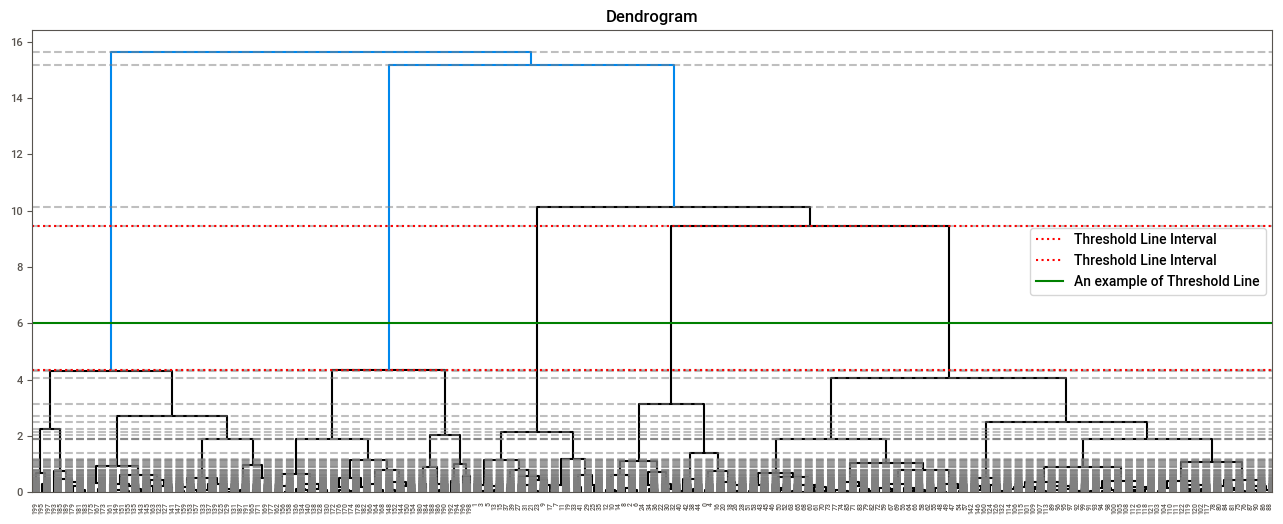

In [1251]:
plt.figure(figsize=(16, 6))
clusters = shc.linkage(X_2f_scaled, method='ward', metric="euclidean")
dendrogram = shc.dendrogram(Z=clusters)

# Draw horizontal lines for each merge level
# Heights of merges (3rd column of linkage matrix)
merge_heights = clusters[:, 2]  
for height in merge_heights:
    plt.axhline(y=height, color='gray', linestyle='--', alpha=0.5)

# Calculate differences between i and i+1
# periods=1 calculates i - (i-1)
diff_heights = pd.Series(merge_heights).diff(periods=1)
idxmax = diff_heights.idxmax()
upper_bound = merge_heights[idxmax]
lower_bound = merge_heights[idxmax - 1]

plt.axhline(y=upper_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=lower_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=6, color='green', label='An example of Threshold Line')
plt.title("Dendrogram")
plt.legend()
plt.show()

(199,)


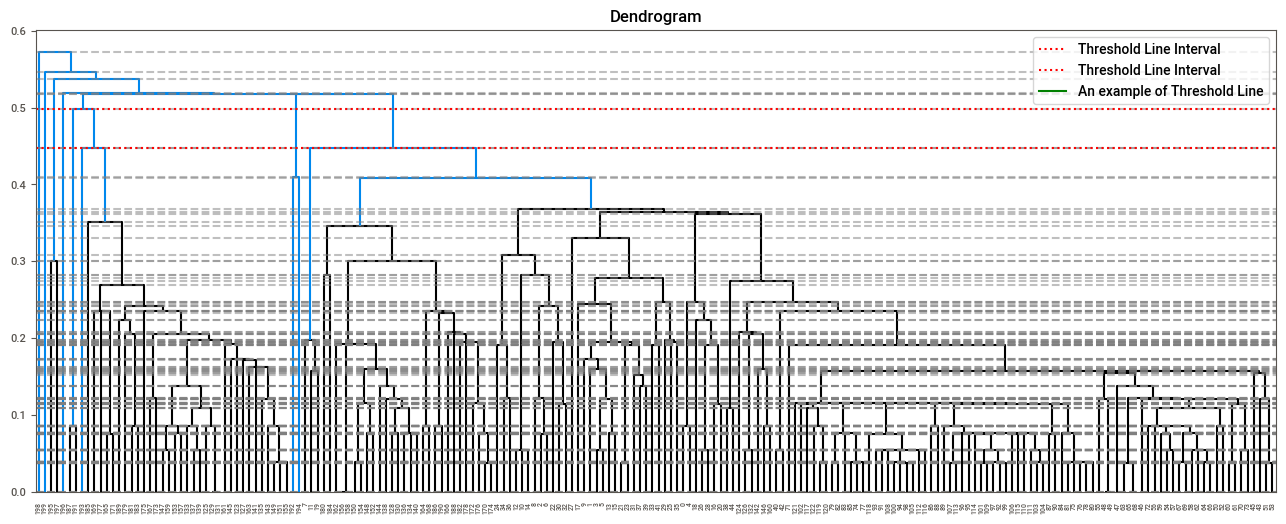

In [1261]:
plt.figure(figsize=(16, 6))
clusters = shc.linkage(X_2f_scaled, method='single', metric="euclidean")
dendrogram = shc.dendrogram(Z=clusters)

# Draw horizontal lines for each merge level
# Heights of merges (3rd column of linkage matrix)
merge_heights = clusters[:, 2]  
for height in merge_heights:
    plt.axhline(y=height, color='gray', linestyle='--', alpha=0.5)

# Calculate differences between i and i+1
# periods=1 calculates i - (i-1)
diff_heights = pd.Series(merge_heights).diff(periods=1)
idxmax = diff_heights.idxmax()
upper_bound = merge_heights[idxmax]
lower_bound = merge_heights[idxmax - 1]

plt.axhline(y=upper_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=lower_bound, color='r', linestyle=':', label='Threshold Line Interval')
plt.axhline(y=6, color='green', label='An example of Threshold Line')
plt.title("Dendrogram")
plt.legend()
plt.show()

In [1272]:
compare_ = pd.DataFrame() 
methods = ['ward', 'median', 'centroid', 'weighted', 'average', 'complete', 'single']
for m in methods:
    Z = shc.linkage(X_2f_scaled, method=m, metric="euclidean")
    merge_heights = Z[:, 2]  
    diff_heights = pd.Series(merge_heights).diff(periods=1)
    idxmax = diff_heights.idxmax()
    upper_bound = merge_heights[idxmax]
    lower_bound = merge_heights[idxmax - 1] if idxmax > 0 else 0 
    
    new_row = pd.DataFrame({
        "method": [m],
        "lower_bound": [lower_bound],
        "upper_bound": [upper_bound]
    })
    compare_ = pd.concat([compare_, new_row], ignore_index=True)

compare_['bound_lenght'] = compare_['upper_bound'] - compare_['lower_bound']

---- For method: "ward", boundaries for threshold: [4.354422154062322, 9.45335290729604]
---- For method: "median", boundaries for threshold: [1.8012841667869688, 2.4136672212130983]
---- For method: "centroid", boundaries for threshold: [0.9298595215434331, 1.5638138600659617]
---- For method: "weighted", boundaries for threshold: [2.62915387341004, 3.2457352449930506]
---- For method: "average", boundaries for threshold: [1.0226128230188123, 1.6414813661092944]
---- For method: "complete", boundaries for threshold: [3.909214240849835, 5.501475005032089]
---- For method: "single", boundaries for threshold: [0.44715391205796484, 0.4977189098412889]


In [1276]:
compare_

,method,lower_bound,upper_bound,bound_lenght
0,ward,4.354422,9.453353,5.098931
1,median,1.801284,2.413667,0.612383
2,centroid,0.929860,1.563814,0.633954
3,weighted,2.629154,3.245735,0.616581
4,average,1.022613,1.641481,0.618869
5,complete,3.909214,5.501475,1.592261
6,single,0.447154,0.497719,0.050565


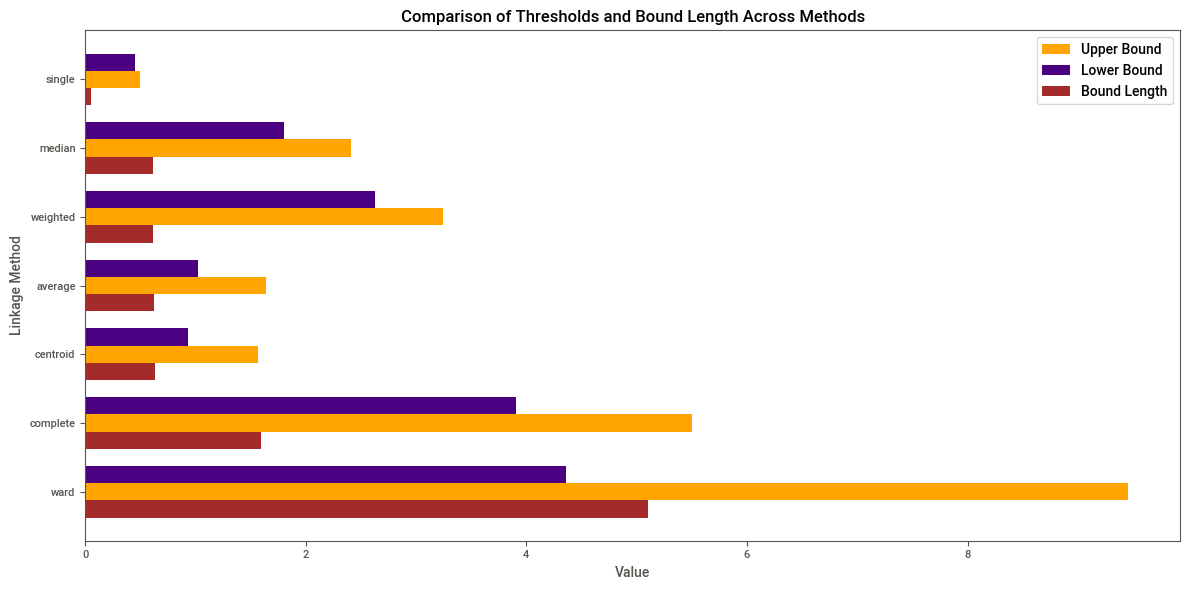

In [1297]:
compare_ = compare_.sort_values(by='bound_lenght', ascending=False)

plt.figure(figsize=(12, 6))
x = np.arange(len(compare_['method']))
width = 0.25

plt.barh(x, compare_['upper_bound'], width, label='Upper Bound', color='orange')
plt.barh(x + width, compare_['lower_bound'], width, label='Lower Bound', color='indigo')
plt.barh(x - width, compare_['bound_lenght'], width, label='Bound Length', color='brown')
plt.yticks(x, compare_['method'])

plt.xlabel("Value")
plt.ylabel("Linkage Method")
plt.title("Comparison of Thresholds and Bound Length Across Methods")
plt.legend()
plt.tight_layout()
plt.show()

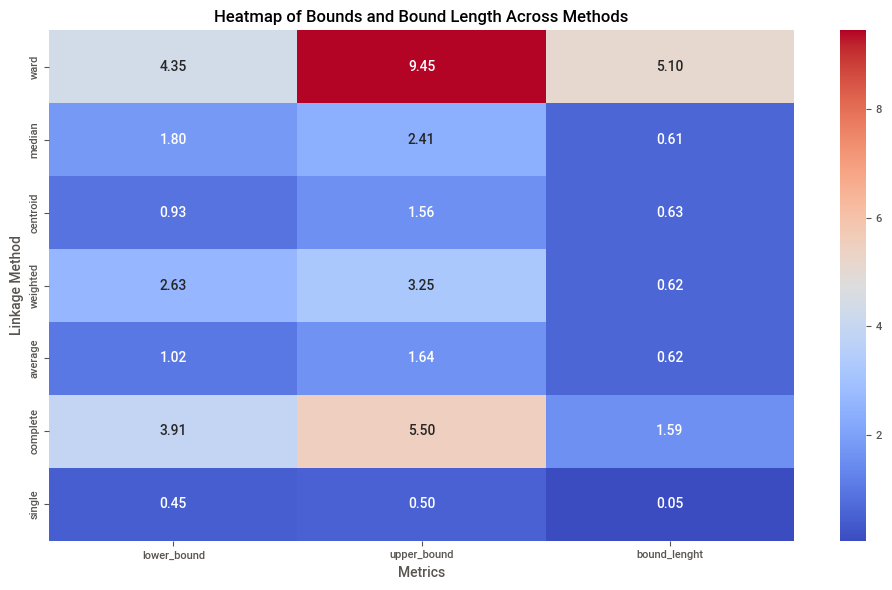

In [1281]:
heatmap_data = compare_[['lower_bound', 'upper_bound', 'bound_lenght']].set_index(compare_['method'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Bounds and Bound Length Across Methods")
plt.ylabel("Linkage Method")
plt.xlabel("Metrics")
plt.tight_layout()
plt.show()

___

## Interpretation



Single Linkage shows the least separation:
- the clusters are quite close to each other
- there is minimal separation between them which can result in poor separation between distinct groups

<br>


Median, Centroid, Weighted, and Average show moderate cluster separation:
- indicating intermediate clustering behavior between well-separated and closely grouped clusters


<br>


Ward and Complete Linkage methods show the most significant cluster separation with the highest boundary lengths
- indicating they form more distinct and well-separated clusters

  
> Depending on the clustering method used, the number and the distinctness of clusters will vary
>
> Ward and Complete providing more reliable separation
>
> Single linkage possibly producing a more fused clustering result